<center><h1>The Annotated Transformer (2025)</h1> </center>


<center>
<p><a href="https://arxiv.org/abs/1706.03762">Attention is All You Need
</a></p>
</center>




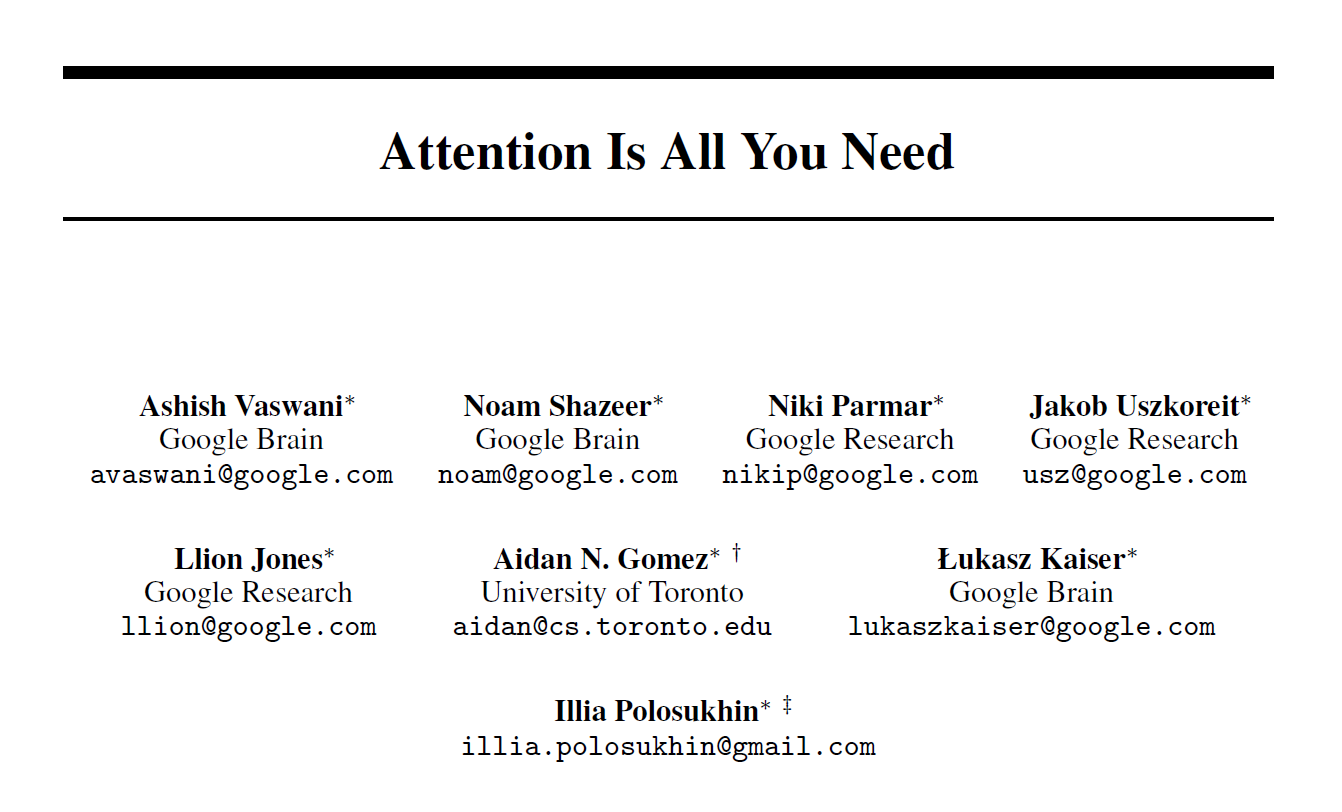

In [1]:
from IPython.display import Image
Image(filename='images/paper.png', width=800)

This an updated version of the [The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/), extending the original implementation to support English-to-Chinese translation using a custom-trained modern tokenizer (e.g., RoBERTa).  

This version also replaces Altair with Plotly for visualization and enhances several components, including data loading, batching and data collation. 

Additionally, fixes and improvements are applied to the attention visualization.

<br>



References:
* *[v2022: Austin Huang, Suraj Subramanian, Jonathan Sum, Khalid Almubarak,
   and Stella Biderman]((https://nlp.seas.harvard.edu/annotated-transformer/)).* 
   > The associated github repository can be found at https://github.com/harvardnlp/annotated-transformer
* *[Original: Sasha Rush](https://nlp.seas.harvard.edu/2018/04/03/attention.html).*

<br>


# Table of Contents
<ul>

<li><a href="#prelims">Preliminaries</a></li>

<li><a href="#background">Background</a></li>

<li><a href="#part-1-model-architecture">Part 1: Model Architecture</a></li><ul>
<li><a href="#model-architecture">Model Architecture</a></li>
<li><a href="#positional-encoding">Positional Encoding</a></li>
<li><a href="#embeddings-and-softmax">Embeddings</a></li>
<li><a href="#layernorm">LayerNorm</a></li>
<li><a href="#position-wise-feed-forward-networks">Position-wise Feed-Forward
Networks</a></li>
<li><a href="#attention">Attention</a></li>
<li><a href="#encoder-and-decoder-stacks">Encoder and Decoder Stacks</a></li>
<li><a href="#transformer">Transformer Model</a></li>
<li><a href="#full-model">Create Full Model</a></li>
<li><a href="#inference">Inference Test</a></li>
</ul></li>

<li><a href="#part-2-model-training">Part 2: Preparation for Training</a></li><ul>
<li><a href="#batches-and-masking">Batching and Masking</a></li>
<li><a href="#optimizer">Optimizer and Scheduler</a></li>
<li><a href="#training-loop">Training Loop</a></li>
</ul></li>

<li><a href="#part-3-toy-example">Part 3: Toy Training Example</a></li><ul>
<li><a href="#synthetic-data">Synthetic Data</a></li>
<li><a href="#loss-computation">Loss Computation</a></li>
<li><a href="#greedy-decoding">Greedy Decoding</a></li>
<li><a href="#train-loop">Training Loop</a></li>
<li><a href="#train-model">Train the Simple Model</a></li>
</ul></li>

<li><a href="#part-4-a-real-world-example">Part 4: A Real World Example</a></li>
<ul>
<li><a href="#data-loading">Data Loading</a></li>
<li><a href="#iterators">Train Tokenizer</a></li>
<li><a href="#tokenize-data">Tokenize Data</a></li>
<li><a href="#pad-sequence">Pad Sequence Examples</a></li>
<li><a href="#datacollator">Data Collator and Dataloader</a></li>
<li><a href="#training-the-system">Train the System</a></li>
<li><a href="#greedy-decoding">Greedy Decoding and Check Results</a></li>
</ul></li>

<li><a href="#results">Part 5: Attention Visualization</a></li><ul>
<li><a href="#one-example">One example from eval dataset</a></li>
<li><a href="#encoder-self-attention">Encoder Visualization: Self Attention</a></li>
<li><a href="#decoder-self-attention">Decoder Visualization [greedy decoding]: Self Attention</a></li>
<li><a href="#decoder-cross-attention">Decoder Visualization [greedy decoding]: Cross Attention</a></li>
<li><a href="#decoder-self-attention">Decoder Visualization [teacher force]: Self Attention</a></li>
<li><a href="#decoder-cross-attention">Decoder Visualization [teacher force]: Cross Attention</a></li>
</ul></li>

<li><a href="#conclusion">Conclusion</a></li>
</ul>

In this tutorial, I changed the order of the components compared to the previous one. The model architecture comes first, followed by positional encoding, embedding, the feed-forward network, attention, the encoder, and the decoder. 

Finally, the full model is created, and a toy example and a real world example are given.

<br>

# Preliminaries

This tutorial is tested in:
* python=3.12.7
* CUDA=11.8

In [2]:
## Core python packages

# pandas==2.2.3
# datasets==3.0.1
# plotly==5.24.1
# torch==2.4.1
# transformers==4.45.2

# GPUtil==1.4.0

In [3]:
# !pip install GPUtil datasets==3.0.1

In [4]:
# Install torch 2.4.1 when necessary
# !pip install torch==2.4.1 transformers==4.45.2

In [5]:
import os
import math
import copy
import time
from tqdm import tqdm
from dataclasses import dataclass
from typing import Union, Optional, List, Dict, Any


import GPUtil
import plotly
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torch.nn.utils.rnn import pad_sequence

import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP

import datasets
from transformers import AutoTokenizer, PreTrainedTokenizerBase

# import warnings
# warnings.filterwarnings("ignore")

In [6]:
torch.cuda.is_available()

True

In [7]:
# If cuda is available
if torch.cuda.is_available():
    GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |


<br>

# Background

The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models to
be superior in quality while being more parallelizable and requiring significantly
less time to train. Our model achieves 28.4 BLEU on the WMT 2014 Englishto-
German translation task, improving over the existing best results, including
ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task,
our model establishes a new single-model state-of-the-art BLEU score of 41.0 after
training for 3.5 days on eight GPUs, a small fraction of the training costs of the
best models from the literature.


The goal of reducing sequential computation also forms the
foundation of the Extended Neural GPU, ByteNet and ConvS2S, all of
which use convolutional neural networks as basic building block,
computing hidden representations in parallel for all input and
output positions. In these models, the number of operations required
to relate signals from two arbitrary input or output positions grows
in the distance between positions, linearly for ConvS2S and
logarithmically for ByteNet. This makes it more difficult to learn
dependencies between distant positions. In the Transformer this is
reduced to a constant number of operations, albeit at the cost of
reduced effective resolution due to averaging attention-weighted
positions, an effect we counteract with Multi-Head Attention.

Self-attention, sometimes called intra-attention is an attention
mechanism relating different positions of a single sequence in order
to compute a representation of the sequence. Self-attention has been
used successfully in a variety of tasks including reading
comprehension, abstractive summarization, textual entailment and
learning task-independent sentence representations. 

End-to-end memory networks are based on a recurrent attention mechanism instead
of sequencealigned recurrence and have been shown to perform well on
simple-language question answering and language modeling tasks.

To the best of our knowledge, however, the Transformer is the first
transduction model relying entirely on self-attention to compute
representations of its input and output without using sequence
aligned RNNs or convolution.

<br>

# Part 1: Model Architecture

## Model Architecture


Most competitive neural sequence transduction models have an
encoder-decoder structure. Here, the encoder maps an
input sequence of symbol representations $(x_1, ..., x_n)$ to a
sequence of continuous representations $\mathbf{z} = (z_1, ...,
z_n)$. Given $\mathbf{z}$, the decoder then generates an output
sequence $(y_1,...,y_m)$ of symbols one element at a time. At each
step the model is auto-regressive, consuming the previously
generated symbols as additional input when generating the next.


The Transformer follows this overall architecture using stacked
self-attention and point-wise, fully connected layers for both the
encoder and decoder, shown in the left and right halves of Figure 1,
respectively.

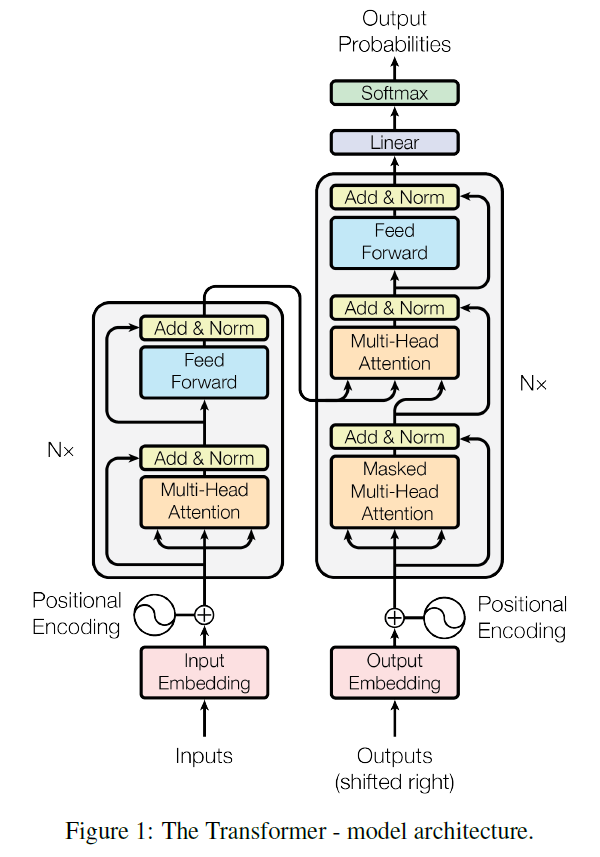

In [8]:
Image(filename='images/transformer.png', width=500)

<br>

## Positional Encoding

Since Transformer contains no recurrence and no convolution, in order
for the model to make use of the order of the sequence, we must
inject some information about the relative or absolute position of
the tokens in the sequence.  To this end, we add "positional
encodings" to the input embeddings at the bottoms of the encoder and
decoder stacks.  The positional encodings have the same dimension
$d_{\text{model}}$ as the embeddings, so that the two can be summed.
There are many choices of positional encodings, learned and fixed.

In this work, we use sine and cosine functions of different frequencies:

$$PE_{(pos,2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})$$

where $pos$ is the position and $i$ is the dimension.  That is, each
dimension of the positional encoding corresponds to a sinusoid.  The
wavelengths form a geometric progression from $2\pi$ to $10000 \cdot
2\pi$.  We chose this function because we hypothesized it would
allow the model to easily learn to attend by relative positions,
since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a
linear function of $PE_{pos}$.

We also experimented with using learned positional embeddings instead, and found that the two
versions produced nearly identical results.
We chose the sinusoidal version because it may allow the model to extrapolate
to sequence lengths longer than the ones encountered during training.

In addition, we apply dropout to the sums of the embeddings and the
positional encodings in both the encoder and decoder stacks.  For
the base model, we use a rate of $P_{drop}=0.1$.




In [9]:
def create_fixed_positional_encoding(dim, max_len=5000):
    "Implement the PE function."

    # Compute the positional encodings once in log space.
    pe = torch.zeros(max_len, dim)                      # empty encodings vectors
    position = torch.arange(0, max_len).unsqueeze(1)    # position index

    # $10000^{\frac{2i}{d_{model}}}$
    div_term = torch.exp(
        torch.arange(0, dim, 2) * -(math.log(10000.0) / dim)
    )

    # $PE_{p,2i} = sin\Bigg(\frac{p}{10000^{\frac{2i}{d_{model}}}}\Bigg)$
    pe[:, 0::2] = torch.sin(position * div_term)

    # $PE_{p,2i + 1} = cos\Bigg(\frac{p}{10000^{\frac{2i}{d_{model}}}}\Bigg)$
    pe[:, 1::2] = torch.cos(position * div_term)

    # add batch dimension
    pe = pe.unsqueeze(0).requires_grad_(False)

    return pe   # simple PE (without embedding info)


> Below is an example of the positional encoding which will add in a 
> sine/cosine wave based on position. 
> The frequency and offset of the wave is different for each dimension.

In [10]:
import plotly.express as px

pe = create_fixed_positional_encoding(20, 5000)       # pe: [1, max_seq_len, d_model]

frames = []
for dim in [4, 5, 6, 7]:
    d = {
        'Position': list(range(101)),
        'Embedding': pe[0, :101, dim],
        'Dimension': dim,
    }
    frames.append(pd.DataFrame(d))
df = pd.concat(frames)
fig = px.line(
    df, x="Position", y="Embedding", color="Dimension", title='Positional Encoding', template='none',
)

fig.update_layout(
    width=800, height=400,
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=5,
        range=[0, 100],
    ),
    yaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=0.25,
        # range=[-1, 1],
    ),
)

fig.show()


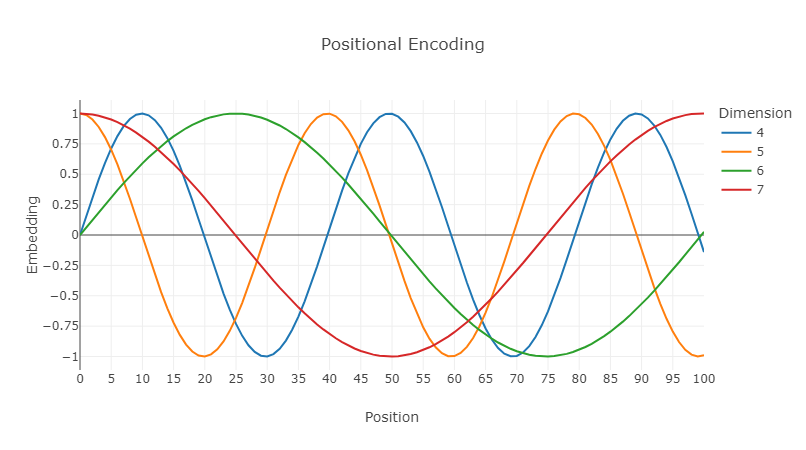

In [11]:
Image(filename='./images/pe.png')

<br>

## Embeddings
Similarly to other sequence transduction models, we use learned
embeddings to convert the input tokens and output tokens to vectors
of dimension $d_{\text{model}}$.  We also use the usual learned
linear transformation and softmax function to convert the decoder
output to predicted next-token probabilities.  In our model, we
share the same weight matrix between the two embedding layers and
the pre-softmax linear transformation, similar to
[(cite)](https://arxiv.org/abs/1608.05859). In the embedding layers,
we multiply those weights by $\sqrt{d_{\text{model}}}$.

In [12]:
# version 2022
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.lut = nn.Embedding(vocab, d_model)     # lut: lookup table
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

> We can combine PositionalEncoding with Token Embedding:

In [13]:
class EmbeddingsWithPositionalEncoding(nn.Module):
    
    def __init__(self, vocab_size, dim, dropout=0.1, pe_type='fixed', max_len=50000):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, dim)
        self.dim = dim
        
        if pe_type == 'fixed':      # fixed positional encoding
            pe = create_fixed_positional_encoding(dim, max_len)
            self.register_buffer('pe', pe)              # requires_grad=False
        else:                       # learned positional encoding
            self.pe = nn.Parameter(torch.zeros(1, max_len, dim))    # requires_grad=True (defaults to True)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        Args:
            x: Tensor, shape (batch_size, seq_len)
        """
        
        # word/token embedding
        token_embedding = self.embed(x) * math.sqrt(self.dim)     # return shape: (batch_size, seq_len, embed_dim)

        # positional encoding
        positional_encoding = self.pe[:, :x.size(1)]           # return shape: (1, seq_len, embed_dim)
        
        return self.dropout(token_embedding + positional_encoding)

<br>

## LayerNorm

In [14]:
# version 2022
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [15]:
class LayerNorm(nn.Module):

    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.bias = nn.Parameter(torch.zeros(dim))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.weight * (x - mean) / (std + self.eps) + self.bias


# Can be replaced by: `nn.LayerNorm`
# https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

<br>

## Position-wise Feed-Forward Networks

In addition to attention sub-layers, each of the layers in our
encoder and decoder contains a fully connected feed-forward network,
which is applied to each position separately and identically.  This
consists of two linear transformations with a ReLU activation in
between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

While the linear transformations are the same across different
positions, they use different parameters from layer to
layer. Another way of describing this is as two convolutions with
kernel size 1.  The dimensionality of input and output is
$d_{\text{model}}=512$, and the inner-layer has dimensionality
$d_{ff}=2048$.

In [16]:
# version 2022
class FeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

In [17]:
class FeedForward(nn.Module):

    def __init__(self, embed_dim, dropout=0.0, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(embed_dim, 4*embed_dim, bias=bias)     # middle layer size is set as 4*embed_dim
        self.linear2 = nn.Linear(4*embed_dim, embed_dim, bias=bias)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

<br>

## Attention

An attention function can be described as mapping a query and a set
of key-value pairs to an output, where the query, keys, values, and
output are all vectors.  The output is computed as a weighted sum of
the values, where the weight assigned to each value is computed by a
compatibility function of the query with the corresponding key.


### Scaled Dot-Product Attention

We call our particular attention "Scaled Dot-Product Attention".
The input consists of queries and keys of dimension $d_k$, and
values of dimension $d_v$.  We compute the dot products of the query
with all keys, divide each by $\sqrt{d_k}$, and apply a softmax
function to obtain the weights on the values.



In practice, we compute the attention function on a set of queries
simultaneously, packed together into a matrix $Q$.  The keys and
values are also packed together into matrices $K$ and $V$.  We
compute the matrix of outputs as:

$$
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

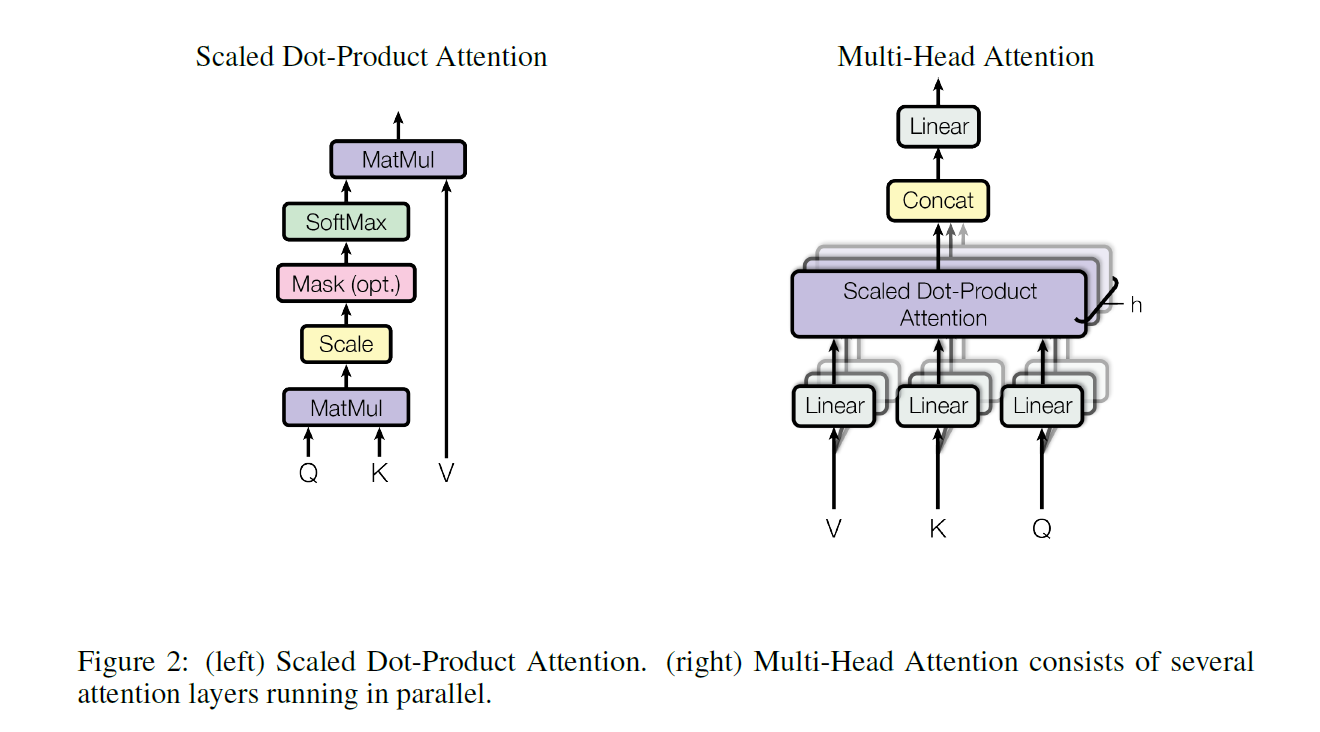

In [18]:
Image(filename='images/attention.png', width=900)

In [19]:
# version 2022
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


The two most commonly used attention functions are additive
attention, and dot-product
(multiplicative) attention.  Dot-product attention is identical to
our algorithm, except for the scaling factor of
$\frac{1}{\sqrt{d_k}}$. Additive attention computes the
compatibility function using a feed-forward network with a single
hidden layer.  While the two are similar in theoretical complexity,
dot-product attention is much faster and more space-efficient in
practice, since it can be implemented using highly optimized matrix
multiplication code.


While for small values of $d_k$ the two mechanisms perform
similarly, additive attention outperforms dot product attention
without scaling for larger values of $d_k$. We suspect that for
large values of $d_k$, the dot products grow large in magnitude,
pushing the softmax function into regions where it has extremely
small gradients (To illustrate why the dot products get large,
assume that the components of $q$ and $k$ are independent random
variables with mean $0$ and variance $1$.  Then their dot product,
$q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance
$d_k$.). To counteract this effect, we scale the dot products by
$\frac{1}{\sqrt{d_k}}$.

<br>


### Multi-Head Attention

Multi-head attention allows the model to jointly attend to
information from different representation subspaces at different
positions. With a single attention head, averaging inhibits this.

$$
\mathrm{MultiHead}(Q, K, V) =
    \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

Where the projections are parameter matrices $W^Q_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in
\mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in
\mathbb{R}^{hd_v \times d_{\text{model}}}$.

In this work we employ $h=8$ parallel attention layers, or
heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due
to the reduced dimension of each head, the total computational cost
is similar to that of single-head attention with full
dimensionality.

In [ ]:
# version 2022
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super().__init__()
        assert d_model % h == 0, "embeding dim (d_model) must be divisible by number of heads (h)"
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.attn = None    # record attention score
        self.dropout = nn.Dropout(p=dropout)
        
        # query, key, value (QKV) projections for all heads
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)

        # output projection
        self.out_proj = nn.Linear(d_model, d_model)


    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        # nbatches, seq_len, d_model = query.size()     # 【query】的维度为：batch size (nbatches)[batch first], sequence length (seq_len), embedding dimension (d_model)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k
        query = self.q_proj(query).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) # d_model => h x d_k：实现了 multihead attention（多头注意力机制）
        key = self.k_proj(key).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        value = self.v_proj(value).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        
        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )
        
        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)  # 通过view/reshape，巧妙地实现了concat multihead的操作
        )
        del query
        del key
        del value
        
        return self.out_proj(x)     # 此时返回的变量其维度为：[nbatches, seq_len, d_model]

In [21]:
class MultiHeadAttention(nn.Module):
    
    def __init__(
        self,
        embed_dim,
        num_heads,
        dropout: float = 0.1,
        bias: bool = True,
        ):

        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim (d_model) must be divisible by num_heads"
        self.head_dim = embed_dim // num_heads      # d_k
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.attn_score = None    # record attention score
        
        # scaling factor
        self.scaling = self.head_dim**-0.5

        # query, key, value (QKV) projections for all heads
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

        # output projection
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

        self.dropout = nn.Dropout(dropout)
        
        # parameter initialization can be done later after the full model is created
        # self.reset_parameters()
    
    # def reset_parameters(self):
    #     nn.init.xavier_normal_(self.q_proj.weight)
    #     nn.init.xavier_normal_(self.k_proj.weight)
    #     nn.init.xavier_normal_(self.v_proj.weight)
    #     nn.init.xavier_uniform_(self.out_proj.weight)
    #     if self.out_proj.bias is not None:
    #         nn.init.constant_(self.out_proj.bias, 0.0)
    
    def forward(
        self, 
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask=None,
        return_weights=False
        ):

        bsz, seq_len, embed_dim = query.size()      # batch size (bsz)[batch first], sequence length (query), embedding dimensionality (embed_dim)
        assert embed_dim == self.embed_dim
        assert key.size() == value.size()           # key = value
        
        # 1. Q/K/V projections in batch from d_model => h x d_k
        # calculate query, key, value for all heads in batch 
        # and move head forward to be the batch dim
        q = self.q_proj(query).view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)     # bsz, num_heads, seq_len, head_dim
        k = self.k_proj(key).view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)       # bsz, num_heads, seq_len, head_dim
        v = self.v_proj(value).view(bsz, -1, self.num_heads, self.head_dim).transpose(1, 2)     # bsz, num_heads, seq_len, head_dim 
        
        # implementation of attention
        # scores = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        scores = (q @ k.transpose(-2, -1)) * self.scaling     # bsz, num_heads, seq_len (query), seq_len (key)
        
        # masked attention
        if mask is not None:
            mask = mask.unsqueeze(1)        # broadcast: same mask applied to all (num_heads) attention heads
            scores = scores.masked_fill(mask == 0, float('-inf'))   # elements with 0 are masked
        
        # attention weight/probability
        attn = F.softmax(scores, dim=-1)    # dim in key sequence
        
        if self.dropout is not None:
            attn = self.dropout(attn)
        
        self.attn_score = attn              # record attention score
        
        # attended/weighted sum
        # (bsz, num_heads, seq_len, seq_len) x (bsz, num_heads, seq_len, head_dim) -> (bsz, num_heads, seq_len, head_dim)
        values = attn @ v
        # values = torch.matmul(attn, v)
        # values = torch.bmm(attn, v)
        
        # combine multihead attn (reshape)
        # (bsz, num_heads, seq_len, head_dim) -> (bsz, seq_len, num_heads, head_dim) -> (bsz, seq_len, embed_dim)
        values = values.transpose(1, 2).reshape(bsz, seq_len, embed_dim)
        # values = values.permute(0, 2, 1, 3).contiguous().view(bsz, seq_len, embed_dim)
        
        # output projection
        out = self.out_proj(values)        # bsz, seq_len, embed_dim
        
        if return_weights:          # return attention weights
            return out, attn
        return out

<br>

### Applications of Attention in our Model

The Transformer uses multi-head attention in three different ways:
1) In "encoder-decoder attention" layers, the queries come from the
previous decoder layer, and the memory keys and values come from the
output of the encoder.  This allows every position in the decoder to
attend over all positions in the input sequence.  This mimics the
typical encoder-decoder attention mechanisms in sequence-to-sequence
models.


2) The encoder contains self-attention layers.  In a self-attention
layer all of the keys, values and queries come from the same place,
in this case, the output of the previous layer in the encoder.  Each
position in the encoder can attend to all positions in the previous
layer of the encoder.


3) Similarly, self-attention layers in the decoder allow each
position in the decoder to attend to all positions in the decoder up
to and including that position.  We need to prevent leftward
information flow in the decoder to preserve the auto-regressive
property.  We implement this inside of scaled dot-product attention
by masking out (setting to $-\infty$) all values in the input of the
softmax which correspond to illegal connections.

<br>

## Encoder and Decoder Stacks

### Encoder

The encoder is composed of a stack of $N=6$ identical layers. 
Each layer has two sub-layers. The first is a multi-head
self-attention mechanism, and the second is a simple, position-wise
fully connected feed-forward network.


We employ a residual connection around each of the two
sub-layers, followed by layer normalization.


That is, the output of each sub-layer is $\mathrm{LayerNorm}(x +
\mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function
implemented by the sub-layer itself.  We apply dropout to the
output of each sub-layer, before it is added to the sub-layer input
and normalized.

To facilitate these residual connections, all sub-layers in the
model, as well as the embedding layers, produce outputs of dimension
$d_{\text{model}}=512$.

In [22]:
# version 2022
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.size = size
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        # x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # return self.sublayer[1](x, self.feed_forward)

        # 1. self-attention sublayer
        norm_x = self.norm(x)       # pre-norm, instead of post-norm【这里和文章不一致，先对输入x进行了norm（也称为pre-norm），而文章中是最后才做了norm（也称为post-norm）】
        attn_output = self.self_attn(norm_x, norm_x, norm_x, mask)
        x = x + self.dropout(attn_output)

        # 2. feedforward sublayer
        norm_x = self.norm(x)
        ff_output = self.feed_forward(norm_x)
        return x + self.dropout(ff_output)


In [23]:
class EncoderLayer(nn.Module):
    """
    EncoderLayer consists of self-attention and feed forward layers
    """
    def __init__(self, embed_dim, num_heads, dropout=0.1, pre_norm=True):
        super().__init__()

        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.ff = FeedForward(embed_dim, dropout)

        self.norm_self_attn = LayerNorm(embed_dim)
        self.norm_ff = LayerNorm(embed_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.pre_norm = pre_norm
    
    def forward(self, x, mask):

        if self.pre_norm:       # pre-norm
            # 1. self-attention sublayer
            norm_x = self.norm_self_attn(x)
            x = x + self.dropout(self.self_attn(norm_x, norm_x, norm_x, mask))
            
            # 2. feedforward sublayer
            norm_x = self.norm_ff(x)
            x = x + self.dropout(self.ff(norm_x))
        else:                   # post-norm
            # 1. self-attention sublayer
            x = x + self.dropout(self.self_attn(x, x, x, mask))
            x = self.norm_self_attn(x)

            # 2. feedforward sublayer
            x = x + self.dropout(self.ff(x))
            x = self.norm_ff(x)
        
        return x

> The encoder is composed of a stack of $N=6$ encoder layers.

In [24]:
# version 2022
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [25]:

class Encoder(nn.Module):
    """
    Encoder consists of multiple EncoderLayer sublayers
    """

    def __init__(self, embed_dim, num_layers, num_heads, dropout=0.1, pre_norm=True):
        super().__init__()
        
        # 先实例化，再deepcopy
        # instantiated once, and deepcopy N times
        encoder_layer = EncoderLayer(embed_dim, num_heads, dropout, pre_norm)
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])  # deepcopy is required
        
        # 或者，直接实例化N次
        # or instantiated N times directly
        # self.layers = nn.ModuleList([EncoderLayer(embed_dim, num_heads, dropout, pre_norm) for _ in range(num_layers)])  # no need to deepcopy

        self.norm = LayerNorm(embed_dim)
    
    def forward(self, x, mask):
        
        for layer in self.layers:
            x = layer(x, mask)

        return self.norm(x)

<br>

### Decoder

The decoder is also composed of a stack of $N=6$ identical layers.



In addition to the two sub-layers in each encoder layer, the decoder
inserts a third sub-layer, which performs multi-head attention over
the output of the encoder stack.  Similar to the encoder, we employ
residual connections around each of the sub-layers, followed by
layer normalization.

In [26]:
# version 2022
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."

        # 1. masked self-attention sublayer【对decoder的input做self-attention (self_attn)】
        norm_x = self.norm(x)   # pre-norm, instead of post-norm【这里和文章不一致，先对输入x进行了norm（也称为pre-norm），而文章中是最后才做了norm（也称为post-norm）】
        attn_output = self.self_attn(norm_x, norm_x, norm_x, tgt_mask)  # 此处的 mask 为tagt_mask（target mask，即decoder输入端的mask）
        x = x + self.dropout(attn_output)

        # 2. cross-attention sublayer【decoder的input 与 encoder的输出 做 cross-attention (src_attn)】
        # memory 即为 encoder 的输出
        norm_x = self.norm(x)               # pre-norm, instead of post-norm
        attn_output = self.src_attn(norm_x, memory, memory, src_mask)   # 此处的 mask 为src_mask（source mask，即 mask encoder端的padding）
                                            # Q = norm_x, K/V = memory
        x = x + self.dropout(attn_output)
        
        # 3. feedforward sublayer
        norm_x = self.norm(x)
        ff_output = self.feed_forward(norm_x)
        return x + self.dropout(ff_output)

In [27]:
class DecoderLayer(nn.Module):
    """
    DecoderLayer consists of self attention, cross attention, and feed forward
    """
    def __init__(self, embed_dim, num_heads, dropout=0.1, pre_norm=True):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.ff = FeedForward(embed_dim, dropout)

        self.norm_self_attn = LayerNorm(embed_dim)
        self.norm_cross_attn = LayerNorm(embed_dim)
        self.norm_ff = LayerNorm(embed_dim)

        self.dropout = nn.Dropout(dropout)
        self.pre_norm = pre_norm
    
    def forward(self, x, memory, src_mask, tgt_mask):   # caution: the order of args should be consistent across modules
        """
        x, tgt_mask : decoder input and associated 'causal' mask (auto-regressive)
        memory, src_mask : encoder output (serves as K, V in cross attention) and associated mask
        """
        
        if self.pre_norm:       # pre-norm
            # 1. masked self-attention sublayer
            norm_x = self.norm_self_attn(x)
            x = x + self.dropout(self.self_attn(norm_x, norm_x, norm_x, tgt_mask))
            
            # 2. cross-attention sublayer
            norm_x = self.norm_cross_attn(x)
            x = x + self.dropout(self.cross_attn(norm_x, memory, memory, src_mask)) # decoder side 'queries' encoder output (memory)
            
            # 3. feedforward sublayer
            norm_x = self.norm_ff(x)
            x = x + self.dropout(self.ff(norm_x))
        else:                   # post-norm
            # 1. masked self-attention sublayer
            x = x + self.dropout(self.self_attn(x, x, x, tgt_mask))
            x = self.norm_self_attn(x)

            # 2. cross-attention sublayer
            x = x + self.dropout(self.cross_attn(x, memory, memory, src_mask))      # decoder side 'queries' encoder output (memory)
            x = self.norm_cross_attn(x)
            
            # 3. feedforward sublayer
            x = x + self.dropout(self.ff(x))
            x = self.norm_ff(x)
        
        return x

> The decoder is also composed of a stack of $N=6$ decoder layers.

In [28]:
# version 2022
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [29]:
class Decoder(nn.Module):
    """
    Decoder consists of multiple DecoderLayer sublayers
    """

    def __init__(self, embed_dim, num_layers, num_heads, dropout=0.1, pre_norm=True):
        super().__init__()

        # # 先实例化，再deepcopy N次
        # Instantiated once, and deepcopy N times
        # decoder_layer = DecoderLayer(embed_dim, num_heads, dropout, pre_norm)
        # self.layers = nn.ModuleList([copy.deepcopy(decoder_layer) for _ in range(num_layers)])  # 需要deepcopy，否则会导致 所有层共享同一组参数，无法实现独立训练

        # 或者，直接实例化N次
        # or instantiated N times directly
        self.layers = nn.ModuleList([DecoderLayer(embed_dim, num_heads, dropout, pre_norm) for _ in range(num_layers)])
        self.norm = LayerNorm(embed_dim)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)

        return self.norm(x)


We also modify the self-attention sub-layer in the decoder stack to
prevent positions from attending to subsequent positions.  This
masking, combined with fact that the output embeddings are offset by
one position, ensures that the predictions for position $i$ can
depend only on the known outputs at positions less than $i$.

In [30]:
def create_causal_mask(size):
    "Mask out subsequent positions to preserve the auto-regressive property."
    attn_shape = (1, size, size)
    causal_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return causal_mask == 0


> Below the attention mask shows the position each target word (row) is
> allowed to look at (column). 
> To preserve the auto-regressive property, words are blocked for attending to
> future words during training.

In [31]:
import plotly.graph_objects as go

n = 21
matrix = create_causal_mask(n).int().numpy()[0]

heat = go.Heatmap(
        z=matrix,
        # x=xlabels,
        # y=ylabels,
        xgap=1, ygap=1,
        colorscale='PuBu',
        colorbar_thickness=20,
        colorbar_ticklen=3,
    )
layout = go.Layout(
    title_text="Causal Mask", 
    title_x=0.5, 
    width=400, height=400,
    yaxis_autorange='reversed', 
    xaxis=dict(
        ticks='outside'
    ),
    yaxis=dict(
        ticks='outside'
    ),
)
fig=go.Figure(data=[heat], layout=layout)
fig.show()

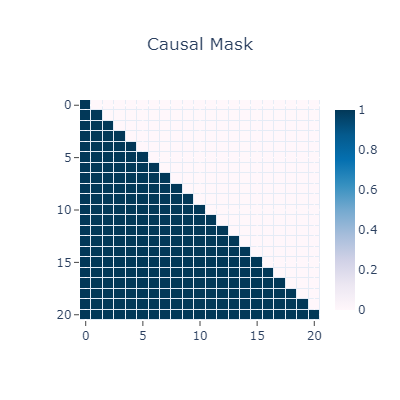

In [32]:
Image(filename='images/causal_mask.png')

<br>

## Transformer Model

> Transformer model consists of Encoder, Decoder, and a final projection layer


In [33]:
class Generator(nn.Module):
    """
    Define decoder side lanaguge model head (`final_proj`, a linear projection) and softmax for generation.
    Note: To tie the weights of final_proj with nn.Embedding, bias term in final_proj is set to be False.
    """
    
    def __init__(self, embed_dim, vocab_size):
        super().__init__()
        self.final_proj = nn.Linear(embed_dim, vocab_size, bias=False)    # projection to vocab size
    
    def forward(self, x):
        return F.log_softmax(self.final_proj(x), dim=-1)      # softmax and log

In [34]:
class Transformer(nn.Module):
    """
    Transformer consists of Encoder, Decoder, and a final projection layers
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim, num_layers, num_heads, dropout=0.1, pre_norm=True, pe_type='fixed'):
        super().__init__()
        
        self.src_embed = EmbeddingsWithPositionalEncoding(src_vocab_size, embed_dim, dropout, pe_type)
        self.tgt_embed = EmbeddingsWithPositionalEncoding(tgt_vocab_size, embed_dim, dropout, pe_type)
        
        self.encoder = Encoder(embed_dim, num_layers, num_heads, dropout, pre_norm)
        self.decoder = Decoder(embed_dim, num_layers, num_heads, dropout, pre_norm)
        
        self.generator = Generator(embed_dim, tgt_vocab_size)

        # post init
        self.post_init()
        
        
    def encode(self, src, src_mask):
        """Encoder process"""
        x = self.src_embed(src)                     # embedding of src
        enc_out = self.encoder(x, src_mask)         # encoder output
        return enc_out
    
    def decode(self, tgt, memory, src_mask, tgt_mask):  # the order of args should be consistent across modules
        """Decoder process"""
        x = self.tgt_embed(tgt)                     # embedding of tgt
        dec_out = self.decoder(x, memory, src_mask, tgt_mask)    # the 'encoder output' serves as K,V in 'decoder cross sttention'
        return dec_out
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        memory = self.encode(src, src_mask)                      # encoder output (memory)
        dec_out = self.decode(tgt, memory, src_mask, tgt_mask)   # decoder output
        return dec_out
    
        # out = self.generator(dec_out)                            # final layer projection
        
    
    def post_init(self):
        "Tie final_proj weight with target embedding weight (defaults to do so)"
        self.generator.final_proj.weight = self.tgt_embed.embed.weight
        print("Source (encoder) and target (decoder) embedding weights are not tied by default.")

    def tie_weights(self):
        """
        Tie source and target embedding weights when necessary.
        For example, tie weights if source and target embeddings use the same vocabulary.
        """
        self.src_embed.embed.weight = self.tgt_embed.embed.weight
        print("Source (encoder) and target (decoder) embedding weights are now tied.")
        
    @property
    def device(self) -> torch.device:
        """
        `torch.device`: The device on which the module is.
        (assuming that all the module parameters are on the same device)
        """
        return next(self.parameters()).device

<br>

<br>

## Create Full Model

> Here we define a function from hyperparameters to a full model.

In [35]:
def create_model(
    src_vocab_size, 
    tgt_vocab_size, 
    embed_dim=512, 
    num_layers=6,
    num_heads=8, 
    dropout=0.1, 
    pre_norm=True, 
    pe_type='fixed',
    device=None,
):
    """
    config: 
        configurations to set the model
        
        - src_vocab_size
        - tgt_vocab_size
        
        - embed_dim
        - num_layers
        - num_heads
        - dropout
        - pre_norm
        - pe_type

        - device
    """
    
    model = Transformer(src_vocab_size, tgt_vocab_size, embed_dim, num_layers, num_heads, dropout, pre_norm, pe_type)
    
    # Initialize model weights
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    if device is not None:      # note: `0` indicates `cuda:0`
        model = model.to(device)
    
    return model

<br>

## Inference Test

#### Use simple cases to quickly test if the implemented code is executable

> Here we make a forward step to generate a prediction of the
model. We try to use our transformer to memorize the input. As you
will see the output is randomly generated due to the fact that the
model is not trained yet. In the next tutorial we will build the
training function and try to train our model to memorize the numbers
from 1 to 10.

In [36]:
def inference_test():
    test_model = create_model(
        src_vocab_size=11, 
        tgt_vocab_size=11, 
        embed_dim=512, 
        num_layers=2, 
        num_heads=8, 
        dropout=0.1, 
        pre_norm=True, 
        pe_type='fixed',
        device=None,
    )
    # do not tie the weight for a random test:
    test_model.generator.final_proj.weight = nn.Parameter(torch.randn_like(test_model.generator.final_proj.weight))

    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)     # note: ys[0]=0, i.e., ys starts with 0
    
    # model rollout
    for i in range(9):
        tgt_mask = create_causal_mask(ys.size(1)).type_as(src.data)
        out = test_model.decode(ys, memory, src_mask, tgt_mask)
        prob = test_model.generator(out[:, -1])     # last token
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)



for _ in range(10):
    inference_test()

Source (encoder) and target (decoder) embedding weights are not tied by default.
Example Untrained Model Prediction: tensor([[0, 5, 5, 8, 7, 8, 7, 8, 7, 8]])
Source (encoder) and target (decoder) embedding weights are not tied by default.
Example Untrained Model Prediction: tensor([[0, 5, 4, 4, 4, 4, 4, 4, 4, 4]])
Source (encoder) and target (decoder) embedding weights are not tied by default.
Example Untrained Model Prediction: tensor([[0, 4, 4, 4, 4, 4, 4, 4, 4, 4]])
Source (encoder) and target (decoder) embedding weights are not tied by default.
Example Untrained Model Prediction: tensor([[ 0,  2,  4, 10, 10, 10, 10, 10, 10, 10]])
Source (encoder) and target (decoder) embedding weights are not tied by default.
Example Untrained Model Prediction: tensor([[ 0,  1, 10,  7, 10, 10, 10, 10, 10, 10]])
Source (encoder) and target (decoder) embedding weights are not tied by default.
Example Untrained Model Prediction: tensor([[0, 1, 9, 7, 6, 9, 3, 1, 9, 5]])
Source (encoder) and target (dec

<br>

# Part 2: Preparation for Training

This section describes the training regime for our models.


> We stop for a quick interlude to introduce some of the tools
> needed to train a standard encoder decoder model. First we define a
> batch object that holds the src and target sentences for training,
> as well as constructing the masks.

### Batching and Masking

In [37]:
create_causal_mask(4)

tensor([[[ True, False, False, False],
         [ True,  True, False, False],
         [ True,  True,  True, False],
         [ True,  True,  True,  True]]])

In [38]:
# 简单的 batch 格式
# simple batching format

# version 2022
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)  # padding mask (unsqueeze for broadcasting)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]     # next token/word prediction
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.num_tokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)       # padding mask (unsqueeze for broadcasting)
        tgt_mask = tgt_mask & create_causal_mask(tgt.size(-1)).type_as(tgt_mask.data)   # add causal mask
        return tgt_mask

In [39]:
# 更强大的 batch 格式控制
# more sophisticated batching format
# ref: https://github.com/huggingface/transformers/blob/v4.45.2/src/transformers/tokenization_utils_base.py#L192

from collections import UserDict
class Batch(UserDict):
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt, pad):
        
        self.data = {}      # ultimate dictionary that stores ('src', 'src_mask', etc.).
        self.data['src'] = src
        self.data['src_mask'] = (src != pad).unsqueeze(-2)
        if tgt is not None:
            # shifted right for next word/token prediction
            self.data['tgt'] = tgt[:, :-1]      # decoder input
            self.data['tgt_y'] = tgt[:, 1:]     # decoder target
            self.data['tgt_mask'] = self.make_std_mask(self.data['tgt'], pad)
            self.data['num_tokens'] = (self.data['tgt_y'] != pad).data.sum()   # num_tokens
        
        super().__init__(self.data)
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & create_causal_mask(tgt.size(-1)).type_as(         # add causal mask
            tgt_mask.data
        )
        return tgt_mask
    
    def __getitem__(self, item: str):
        """
        If the key is a string, returns the value of the dict associated to `key` 
        ('src', 'src_mask', etc.).
        """
        if isinstance(item, str):
            return self.data[item]
        else:
            raise KeyError("Invalid key. Only string of key is available")

    def __getattr__(self, item: str):
        try:
            return self.data[item]
        except KeyError:
            raise AttributeError
        
    def keys(self):
        return self.data.keys()

    def values(self):
        return self.data.values()

    def items(self):
        return self.data.items()

    def device(self):
        return self.data['src'].device

    def to(self, device: Union[str, "torch.device"]):
        """
        Send all values to device by calling `v.to(device)` (PyTorch only).

        Args:
            device (`str` or `torch.device`): The device to put the tensors on.
        """
        
        # This check catches things like APEX blindly calling "to" on all inputs to a module
        # Otherwise it passes the casts down and casts the LongTensor containing the token idxs
        # into a HalfTensor
        if isinstance(device, str) or isinstance(device, int) or isinstance(device, torch.device):
            self.data = {
                k: v.to(device=device) if isinstance(v, torch.Tensor) else v
                for k, v in self.data.items()
            }
        else:
            print(f"warning: Attempting to cast a Batch to type {str(device)}. This is not supported.")
        return self

<br>

## Optimizer and Scheduler

We used the Adam optimizer 
with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$.  We
varied the learning rate over the course of training, according to
the formula:

$$
lrate = d_{\text{model}}^{-0.5} \cdot
  \min({step\_num}^{-0.5},
    {step\_num} \cdot {warmup\_steps}^{-1.5})
$$

This corresponds to increasing the learning rate linearly for the
first $warmup\_steps$ training steps, and decreasing it thereafter
proportionally to the inverse square root of the step number.  


> We can laso use some other optimizers (e.g., `AdamW`) and learning schedulers (e.g., `CosineAnnealingLR`) implemented in PyTorch or other resources.<br>
> For further details, see: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
>
> Note: `AdamW` is an improved version of `Adam` and is thus more widely used now.
> <br>https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html#torch.optim.AdamW

In [40]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )


> Example of the curves of this model for different model sizes and
> for optimization hyperparameters.

In [41]:
# three examples: [model_size, factor, warmup]
examples = [
    [256, 1, 200],
    [512, 1, 200],
    [512, 1, 400],
]

dummy_model = torch.nn.Linear(1, 1)

# three examples
results = []
num_steps = 1001
for idx, example in enumerate(examples):
    # run each example
    optimizer = torch.optim.Adam(
        dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
    )
    
    # save the learning rate at each step
    for step in range(num_steps):
        lr = optimizer.param_groups[0]["lr"]
        optimizer.step()
        lr_scheduler.step()
        # record each step
        d = {
            'step': step,
            'lr': lr,
            'group': f"{example[0]}:{example[2]}"
        }
        results.append(d)

df = pd.DataFrame(results)

# plot
fig = px.line(df, x="step", y="lr", color="group", title='Learning Rate Schedule', template='none',)
fig.update_layout(
    width=800, height=400,
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=100,
        range=[0, 1002],
    ),
    yaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=0.001,
        range=[0, 0.00503],
    ),
)
fig.show()


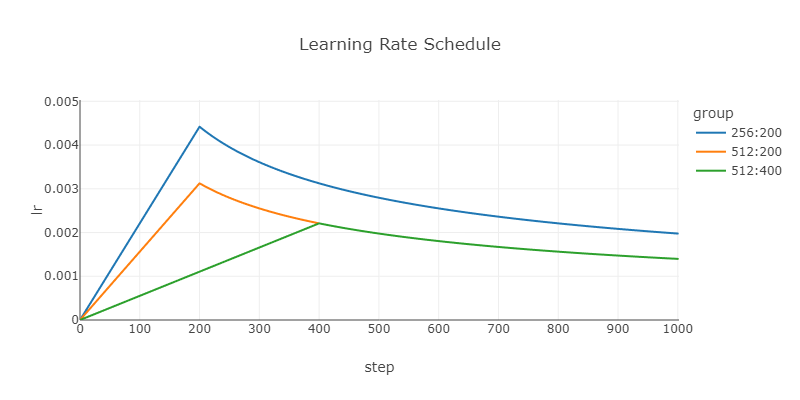

In [42]:
Image(filename='images/scheduler.png')

<br>

<br>

### Cosine Annealing with Warmup

> The scheduler described above depends heavily on model size ($d_{model}$ or $embed\_dim$) which makes it hard to compare across models.
> <br>In practice, we would like to adopt *Cosine Annealing with Warmup*, a widely used learning rate scheduler nowdays, as the scheduler.
> 
> **Cosine Annealing with Warmup**: 
> <br>This creates a schedule with a learning rate that decreases following the values of the cosine function between the
initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
initial lr set in the optimizer.
> <br>Reference code can be found at: https://github.com/huggingface/transformers/blob/v4.45.2/src/transformers/optimization.py#L144

In [43]:
from torch.optim import Optimizer
from functools import partial

def cosine_schedule_with_warmup_lr_lambda(
    current_step: int, *, num_warmup_steps: int, num_training_steps: int, num_cycles: float = 0.5
):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))


def cosine_schedule_with_warmup(
    optimizer: Optimizer, num_warmup_steps: int, num_training_steps: int, num_cycles: float = 0.5, last_epoch: int = -1
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        num_training_steps (`int`):
            The total number of training steps.
        num_cycles (`float`, *optional*, defaults to 0.5):
            The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
            following a half-cosine).
        last_epoch (`int`, *optional*, defaults to -1):
            The index of the last epoch when resuming training.

    Return:
        `torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    lr_lambda = partial(
        cosine_schedule_with_warmup_lr_lambda,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps,
        num_cycles=num_cycles,
    )
    return LambdaLR(optimizer, lr_lambda, last_epoch)


> Example of the curves of cosine annealing with warmup scheduler for different number of warmup steps 
> using AdamW as the optimizer

In [44]:
# three examples: [num_warmup_steps, num_training_steps]
examples = [
    [100, 1000],
    [200, 1000],
    [300, 1000],
]

dummy_model = torch.nn.Linear(1, 1)

# three examples
results = []
base_lr = 0.01
num_steps = 1001
for idx, example in enumerate(examples):
    # run each example
    optimizer = torch.optim.AdamW(
        dummy_model.parameters(), lr=base_lr, betas=(0.9, 0.98), eps=1e-9
    )
    # lr_scheduler = LambdaLR(
    #     optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
    # )

    # lr_scheduler = LambdaLR(
    #     optimizer=optimizer, lr_lambda=lambda step: _get_cosine_schedule_with_warmup_lr_lambda(
    #         step, num_warmup_steps=example[0], num_training_steps=example[1], num_cycles=0.5
    #     )
    # )
    
    lr_scheduler = cosine_schedule_with_warmup(
        optimizer=optimizer, num_warmup_steps=example[0], num_training_steps=example[1]
    )
    
    # save the learning rate at each step
    for step in range(num_steps):
        lr = optimizer.param_groups[0]["lr"]
        optimizer.step()
        lr_scheduler.step()
        # record each step
        d = {
            'step': step,
            'lr': lr,
            'group': f"{example[0]}:{example[1]}"
        }
        results.append(d)

df = pd.DataFrame(results)

# plot
fig = px.line(df, x="step", y="lr", color="group", title='Learning Rate Schedule', template='none',)
fig.update_layout(
    width=800, height=400,
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=100,
        range=[0, 1002],
    ),
    # yaxis=dict(
    #     tickmode='linear',
    #     tick0=0,
    #     dtick=0.002,
    #     range=[0, 0.0102],
    # ),
)
fig.show()


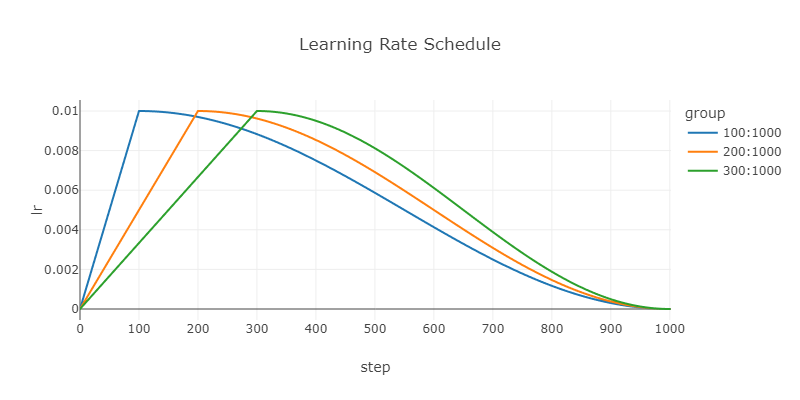

In [45]:
# image of cosine annealing with warmup scheduler
Image(filename='images/cosine_scheduler.png')

<br>

# Part 3: Toy Training Example: Copy input

> We can begin by trying out a simple copy-task. Given a random set
> of input symbols from a small vocabulary, the goal is to generate
> back those same symbols.



## Synthetic Data

In [46]:
def data_generator(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, pad=0)

## Loss Computation

> We simply use cross entropy loss implemented by PyTorch `nn.CrossEntropyLoss`

In [47]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)    # cross entropy loss w/ label smoothing

<br>

### Greedy Decoding

> This code predicts a translation using greedy decoding for simplicity.

In [48]:
@torch.inference_mode
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    model.eval()
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        causal_mask = create_causal_mask(ys.size(1)).type_as(src.data)
        out = model.decode(ys, memory, src_mask, causal_mask)       # decoder input is placed first
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

<br>

> Next we create a generic training and scoring function to keep
> track of loss. We pass in a generic loss compute function that
> also handles parameter updates.

### Training Loop

In [49]:

class TrainState:
    """Track number of steps, examples, and tokens processed"""
    
    step: int = 0           # Steps in the current epoch
    accum_step: int = 0     # Number of gradient accumulation steps
    samples: int = 0        # total # of examples used
    num_tokens: int = 0     # total # of tokens processed


In [50]:
def run_epoch(
    data_iter,
    model,
    criterion,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        batch = batch.to(model.device)      # move inputs to model.device
        logits = model(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        y_pred = model.generator(logits)
        loss = criterion(y_pred.reshape(-1, y_pred.shape[-1]), batch.tgt_y.reshape(-1))
        if mode == "train" or mode == "train+log":
            loss.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.num_tokens += batch.num_tokens.item()
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss.item()
        total_tokens += batch.num_tokens
        tokens += batch.num_tokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        
    return total_loss / total_tokens, train_state

<br>

## Train the Simple Model

> Note: If the learning rate is set too large, the results may not be good enough.

In [51]:
# Train the simple copy task

def run_toy_example(num_epochs=10, pre_norm=True, device='cpu'):
    V = 11
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)    # cross entropy loss w/ label smoothing
    
    model = create_model(V, V, embed_dim=512, num_layers=2, pre_norm=pre_norm)
    model = model.to(device)
    
    num_batches = 20
    batch_size = 80
    warmup_ratio = 0.1  # 10% of total training steps used for a linear warmup
    num_training_steps = num_epochs * num_batches
    num_warmup_steps = math.ceil(num_training_steps * warmup_ratio)
    base_lr=0.001   # lr is important, large lr heats the performance

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=base_lr, betas=(0.9, 0.98), eps=1e-9
    )
    # lr_scheduler = LambdaLR(
    #     optimizer=optimizer,
    #     lr_lambda=lambda step: rate(
    #         step, model_size=512, factor=1.0, warmup=400
    #     ),
    # )
    lr_scheduler = cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

    for epoch in range(num_epochs):
        
        model.train()
        run_epoch(
            data_generator(V, batch_size, nbatches=num_batches),
            model,
            criterion,
            optimizer,
            lr_scheduler,
            mode="train",
        )

    
    model.eval()
    # Inference examples
    src = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]).to(model.device)
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len).to(model.device)
    pred = greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0) # set start_symbol as 0
    print(f"\nTarget:    {src}")
    print(f"Predicted: {pred}")

    src = torch.LongTensor([[0, 1, 3, 5, 7, 9]]).to(model.device)
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len).to(model.device)
    pred = greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0)
    print(f"\nTarget:    {src}")
    print(f"Predicted: {pred}")
    
    src = torch.LongTensor([[0, 9, 2, 6, 4, 1, 6, 9, 8, 9]]).to(model.device)
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len).to(model.device)
    pred = greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0)
    print(f"\nTarget:    {src}")
    print(f"Predicted: {pred}")


In [52]:
# GPU
run_toy_example(num_epochs=20, pre_norm=True, device=0)

Source (encoder) and target (decoder) embedding weights are not tied by default.
Epoch Step:      1 | Accumulation Step:   2 | Loss:  17.05 | Tokens / Sec:  4241.0 | Learning Rate: 5.0e-05
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.48 | Tokens / Sec: 32184.8 | Learning Rate: 5.5e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.38 | Tokens / Sec: 36932.8 | Learning Rate: 1.0e-03
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.35 | Tokens / Sec: 29366.4 | Learning Rate: 9.9e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.35 | Tokens / Sec: 30546.1 | Learning Rate: 9.7e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.36 | Tokens / Sec: 39027.4 | Learning Rate: 9.3e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.27 | Tokens / Sec: 29372.0 | Learning Rate: 8.8e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.11 | Tokens / Sec: 30919.1 | Learning Rate: 8.1e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1

In [53]:
# GPU
run_toy_example(num_epochs=30, pre_norm=False, device=0)

Source (encoder) and target (decoder) embedding weights are not tied by default.
Epoch Step:      1 | Accumulation Step:   2 | Loss:   5.73 | Tokens / Sec: 30707.5 | Learning Rate: 3.3e-05
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.32 | Tokens / Sec: 35590.0 | Learning Rate: 3.7e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.45 | Tokens / Sec: 30931.8 | Learning Rate: 7.0e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.14 | Tokens / Sec: 27512.0 | Learning Rate: 1.0e-03
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.05 | Tokens / Sec: 29655.4 | Learning Rate: 1.0e-03
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.97 | Tokens / Sec: 32652.0 | Learning Rate: 9.9e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.02 | Tokens / Sec: 46364.8 | Learning Rate: 9.7e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.99 | Tokens / Sec: 28848.7 | Learning Rate: 9.4e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1

In [54]:
# CPU
run_toy_example(num_epochs=20, pre_norm=True, device='cpu')

Source (encoder) and target (decoder) embedding weights are not tied by default.
Epoch Step:      1 | Accumulation Step:   2 | Loss:  16.55 | Tokens / Sec:  7008.7 | Learning Rate: 5.0e-05
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.44 | Tokens / Sec:  8290.0 | Learning Rate: 5.5e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.36 | Tokens / Sec:  8262.0 | Learning Rate: 1.0e-03
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.36 | Tokens / Sec:  8177.7 | Learning Rate: 9.9e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.35 | Tokens / Sec:  8104.1 | Learning Rate: 9.7e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.31 | Tokens / Sec:  8095.5 | Learning Rate: 9.3e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.11 | Tokens / Sec:  8219.5 | Learning Rate: 8.8e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.01 | Tokens / Sec:  7930.0 | Learning Rate: 8.1e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1

<br>

<br>

# Part 4: A Real World Example

> Now we consider a real-world example using the
> Chinese-English Translation task to illustrate the whole
> system. 


> The dataset used is available at:
https://github.com/hemingkx/ChineseNMT/tree/master.
> <br>For simplicity, we can also use a subset of the training data.

## Data Loading

> We will load the dataset using `datasets` for
> tokenization.

In [55]:
train_dataset = datasets.load_dataset('json', data_files='data/train.json', split="train")
eval_dataset = datasets.load_dataset('json', data_files='data/dev.json', split="train")

train_dataset = train_dataset.rename_columns({'0': 'english', '1': 'chinese'})
eval_dataset = eval_dataset.rename_columns({'0': 'english', '1': 'chinese'})

In [56]:
train_dataset

Dataset({
    features: ['english', 'chinese'],
    num_rows: 176943
})

In [57]:
train_dataset[100]

{'english': 'When the British economist John Maynard Keynes anticipated the “euthanasia of the rentier” in his 1936 book The General Theory of Employment, Interest and Money, he was referring to a financial class that served no purpose other than to exploit scarce capital for its own benefit.',
 'chinese': '当英国经济学家约翰·梅纳德·凯恩斯（John Maynard Keynes）在他1936年出版的《就业，利益和货币通论》一书中预测“食利者的消亡”时，他指的是一个除了为自身利益尽可能搜刮资本之外什么都不干的金融阶级。'}

<br>


## Train Tokenizer

Train tokenizer from an old one

> RoBERTa is a widely used pretrained language model: https://huggingface.co/docs/transformers/en/model_doc/roberta
> <br>We can use RoBERTa tokenizer as the base tokenizer and train it on our data so that it can better adapt to the specific domain.

In [58]:
from transformers import AutoTokenizer
# load RoBERTa tokenizer
old_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")

In [59]:
# shall be a fast tokenizer
old_tokenizer.is_fast

True

In [60]:
# set train data iterator
def get_training_corpus(batch_size=1000):
    for i in range(0, len(train_dataset), batch_size):
        samples = train_dataset[i : i + batch_size]
        yield samples["english"] + samples["chinese"]

# train data iterator
training_corpus = get_training_corpus()

In [61]:
# train tokenizer from an old one with specified vocabulary size
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, vocab_size=10000)

In [89]:
# Save trained tokenizer to local dir
tokenizer.save_pretrained(save_directory='tokenizer')

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [62]:
# before training the tokenizer
print(old_tokenizer('I love Shanghai!'))
print(old_tokenizer('我爱上海！'))

{'input_ids': [0, 100, 657, 7137, 328, 2], 'attention_mask': [1, 1, 1, 1, 1, 1]}
{'input_ids': [0, 47876, 3602, 36714, 23133, 15389, 48827, 48818, 18400, 43251, 4394, 10172, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [63]:
# after training the tokenizer
print(tokenizer('I love Shanghai!'))
print(tokenizer('我爱上海！'))

{'input_ids': [0, 45, 346, 1626, 3739, 283, 748, 3243, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [0, 584, 3830, 490, 1792, 271, 228, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


<br>

## Tokenize Data

> To better illustrate the process, we only keep `input_ids` from the tokenized data, 
although `attention_mask` is also very useful to construct the masks.

In [64]:
max_seq_length = 128

def preprocess_function(row):
    tokenized_row = {}
    
    # keep `input_ids` only
    tokenized_row['src'] = tokenizer(row['english'], max_length=max_seq_length, truncation=True)['input_ids']
    tokenized_row['tgt'] = tokenizer(row['chinese'], max_length=max_seq_length, truncation=True)['input_ids']

    return tokenized_row


In [65]:
train_dataset = train_dataset.map(
    preprocess_function,
    # remove_columns=column_names,
    desc="Tokenizing",
)

eval_dataset = eval_dataset.map(
    preprocess_function,
    # remove_columns=column_names,
    desc="Tokenizing",
)

In [66]:
train_dataset, eval_dataset

(Dataset({
     features: ['english', 'chinese', 'src', 'tgt'],
     num_rows: 176943
 }),
 Dataset({
     features: ['english', 'chinese', 'src', 'tgt'],
     num_rows: 25278
 }))

In [67]:
example = train_dataset[100]
print(example.keys())
print(example)

dict_keys(['english', 'chinese', 'src', 'tgt'])
{'english': 'When the British economist John Maynard Keynes anticipated the “euthanasia of the rentier” in his 1936 book The General Theory of Employment, Interest and Money, he was referring to a financial class that served no purpose other than to exploit scarce capital for its own benefit.', 'chinese': '当英国经济学家约翰·梅纳德·凯恩斯（John Maynard Keynes）在他1936年出版的《就业，利益和货币通论》一书中预测“食利者的消亡”时，他指的是一个除了为自身利益尽可能搜刮资本之外什么都不干的金融阶级。', 'src': [0, 3131, 270, 3922, 7706, 6568, 5672, 82, 810, 7801, 2738, 7835, 842, 270, 675, 73, 5576, 283, 337, 606, 305, 270, 327, 420, 3404, 457, 293, 1089, 1133, 23, 26, 6856, 2763, 7129, 2763, 1363, 305, 503, 81, 2220, 16, 2610, 1369, 315, 655, 2569, 16, 645, 726, 1571, 272, 4083, 302, 263, 1211, 4374, 362, 2254, 297, 1098, 8752, 950, 797, 302, 5946, 282, 1421, 304, 374, 1830, 393, 648, 1772, 4672, 18, 2], 'tgt': [0, 679, 1511, 3687, 7884, 996, 4301, 8259, 996, 7157, 579, 46, 5357, 5672, 82, 810, 7801, 583, 334, 461, 1260, 23, 

<br>

## Pad Sequence Examples

In [68]:
features = train_dataset.select(range(3))   # a subset of dataset

for row in features:
    print(row)

{'english': 'Military leaders know this, and the threat that they will eventually push him aside will plague his presidency well into next year.', 'chinese': '在担任总理取得实权后，她最终可能会重新审视她与穆沙拉夫的协议。', 'src': [0, 49, 1644, 742, 1493, 2381, 756, 16, 315, 270, 2336, 362, 783, 589, 5942, 5179, 3021, 447, 888, 589, 965, 7750, 1089, 6922, 1532, 1338, 2826, 892, 18, 2], 'tgt': [0, 334, 6433, 3621, 2978, 540, 799, 688, 276, 2546, 2310, 3343, 2674, 3836, 1649, 2546, 661, 2615, 2164, 8600, 268, 2223, 287, 2]}
{'english': 'The researchers concluded that self-reported overall health and depression improved among those who enrolled in Medicaid, and that there was an increase in the diagnosis and treatment of diabetes for this group.', 'chinese': '研究者的结论是，在参加了医疗补助的人中间，自我报告的健康和抑郁情况有所好转，并且这一群体的糖尿病诊断和治疗数量也有所增加。', 'src': [0, 445, 2992, 304, 9442, 6904, 297, 362, 3964, 17, 5622, 496, 297, 6162, 2065, 315, 1895, 3281, 7415, 2511, 1621, 1009, 614, 309, 5908, 293, 6209, 303, 4936, 16, 315, 362, 1142, 726, 500, 2660

In [69]:
from torch.nn.utils.rnn import pad_sequence
to_pad = []
for row in features:
    to_pad.append(torch.LongTensor(row['src']))

pad_sequence(to_pad, batch_first=True, padding_value=tokenizer.pad_token_id)

tensor([[   0,   49, 1644,  742, 1493, 2381,  756,   16,  315,  270, 2336,  362,
          783,  589, 5942, 5179, 3021,  447,  888,  589,  965, 7750, 1089, 6922,
         1532, 1338, 2826,  892,   18,    2,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1],
        [   0,  445, 2992,  304, 9442, 6904,  297,  362, 3964,   17, 5622,  496,
          297, 6162, 2065,  315, 1895, 3281, 7415, 2511, 1621, 1009,  614,  309,
         5908,  293, 6209,  303, 4936,   16,  315,  362, 1142,  726,  500, 2660,
          293,  270, 9343,  624,  286,  315, 6411,  305, 4860,  507,  403,  284,
          393,  756, 2702,   18,    2],
        [   0, 2464,  354,  263, 6042, 3401,  305, 1955,  650, 9505,   76,  482,
         3844,  284,  293, 6003,  273,  315,  950, 4159,  305,  330, 2269,   91,
          466, 3762,   18,    2,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,   

<br>

## Data Collator and Dataloader

> Data collators are objects that will form a batch by using a list of dataset elements as input. 
> These elements are of the same type as the elements of `train_dataset` or `eval_dataset`.
> To be able to build batches, data collators may apply some processing (like padding). 
> Some data collators may also apply some random data augmentation (like random masking) on the formed batch.
> More sophisticate data collator examples can be found at: https://huggingface.co/docs/transformers/en/main_classes/data_collator

> Here we implement the data collator in two ways:
> <br>Either `data_collator_with_padding` or `DataCollatorWithPadding` is ok.

In [70]:
def data_collator_with_padding(features, padding_value):
    src_to_pad = []
    tgt_to_pad = []
    for row in features:
        src_to_pad.append(torch.LongTensor(row['src']))
        tgt_to_pad.append(torch.LongTensor(row['tgt']))
    
    padded_batch = {}
    padded_batch['src'] = pad_sequence(
        src_to_pad,
        batch_first=True,
        padding_value=padding_value
    )
    padded_batch['tgt'] = pad_sequence(
        tgt_to_pad,
        batch_first=True,
        padding_value=padding_value
    )
    # return padded_batch
    
    return Batch(padded_batch['src'], padded_batch['tgt'], pad=padding_value)

In [71]:
@dataclass
class DataCollatorWithPadding:
    """
    Only parameter tokenizer is used in the example, 
    but other parameters may provide additional controls.
    """
    padding_value: int = None      # padding 
    # padding: Union[bool, str] = True
    # pad_to_multiple_of: Optional[int] = None
    # return_tensors: str = "pt"
    
    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        src_to_pad = []
        tgt_to_pad = []
        for row in features:
            src_to_pad.append(torch.LongTensor(row['src']))
            tgt_to_pad.append(torch.LongTensor(row['tgt']))
        
        padded_batch = {}
        padded_batch['src'] = pad_sequence(
            src_to_pad,
            batch_first=True,
            padding_value=self.padding_value
        )
        padded_batch['tgt'] = pad_sequence(
            tgt_to_pad,
            batch_first=True,
            padding_value=self.padding_value
        )
        
        # return padded_batch   # return simple padded batch
        
        # return batched sample with processed `tgt_y` and masks
        return Batch(padded_batch['src'], padded_batch['tgt'], pad=tokenizer.pad_token_id)

In [72]:
data_collator = DataCollatorWithPadding(padding_value=tokenizer.pad_token_id)

# from functools import partial
# data_collator = partial(data_collator_with_padding, padding_value=tokenizer.pad_token_id)

In [73]:
# create data loader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,     # drop last
    collate_fn=data_collator,
)

eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

In [74]:
for batch in train_dataloader:
    break

{k: v.shape for k,v in batch.items()}

{'src': torch.Size([128, 105]),
 'src_mask': torch.Size([128, 1, 105]),
 'tgt': torch.Size([128, 87]),
 'tgt_y': torch.Size([128, 87]),
 'tgt_mask': torch.Size([128, 87, 87]),
 'num_tokens': torch.Size([])}

In [75]:
batch.num_tokens

tensor(3514)

<br>

## Train the System

In [76]:
tokenizer.vocab_size

10000

In [77]:
device = 0
if not torch.cuda.is_available():
    # use cpu if cuda is not available
    device = 'cpu'
print(f'device-{torch.device(device)} is used.')

model = create_model(
    src_vocab_size=tokenizer.vocab_size,
    tgt_vocab_size=tokenizer.vocab_size,
    embed_dim=512,
    num_layers=6,
    pre_norm=True,
    device=device,
)

device-cuda:0 is used.


Source (encoder) and target (decoder) embedding weights are not tied by default.


In [78]:
# model parameters
sum(p.numel() for p in model.parameters() if p.requires_grad)

54380544

In [79]:
# Since we use one tokenier for both source and target inputs in the example,
# we can tie source embedding and target embedding weights
model.tie_weights()

Source (encoder) and target (decoder) embedding weights are now tied.


In [80]:
# model parameters
sum(p.numel() for p in model.parameters() if p.requires_grad)

# Note the differences of number of trainable parameters 
# before and after the weight tie

49260544

In [81]:
# Check if weights are tied
model.src_embed.embed.weight, model.tgt_embed.embed.weight, model.generator.final_proj.weight

(Parameter containing:
 tensor([[-2.2898e-03, -8.1735e-05, -7.7701e-03,  ..., -5.8736e-03,
          -5.2439e-03,  1.1695e-02],
         [ 1.3215e-02,  1.7501e-02,  1.4513e-02,  ...,  9.7311e-03,
          -3.6996e-03,  2.3059e-02],
         [ 1.4331e-02,  2.1782e-02,  2.1754e-02,  ..., -9.6705e-03,
          -1.8476e-02, -1.9765e-02],
         ...,
         [-1.9498e-02,  3.1773e-03,  1.2112e-02,  ..., -1.8529e-02,
           1.1871e-02, -5.2984e-04],
         [-1.6399e-02, -1.6619e-02,  1.4250e-02,  ..., -9.0693e-03,
           8.9425e-03, -1.6677e-02],
         [ 6.8972e-03, -9.1198e-03, -4.2037e-03,  ..., -2.1927e-02,
           8.9233e-03,  1.1309e-02]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-2.2898e-03, -8.1735e-05, -7.7701e-03,  ..., -5.8736e-03,
          -5.2439e-03,  1.1695e-02],
         [ 1.3215e-02,  1.7501e-02,  1.4513e-02,  ...,  9.7311e-03,
          -3.6996e-03,  2.3059e-02],
         [ 1.4331e-02,  2.1782e-02,  2.1754e-02,  ..., -9.670

In [82]:
model.device

device(type='cuda', index=0)

In [83]:
# Train several epochs

def train_epochs(
    model, 
    train_dataloader, 
    criterion,
    optimizer, 
    lr_scheduler=None,
    num_epochs=1,
    save_checkpoint=False,
):
    model.train()
    for epoch in range(num_epochs):
        pbar = tqdm(train_dataloader)
        for i, batch in enumerate(pbar):
            batch = batch.to(model.device)      # move inputs to model.device
            logits = model.forward(             # decoder output
                batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
            )
            y_pred = model.generator(logits)

            loss = criterion(y_pred.reshape(-1, y_pred.shape[-1]), batch.tgt_y.reshape(-1))
            loss.backward()
            optimizer.step()

            lr = optimizer.param_groups[0]["lr"]    # current learning rate
            
            if lr_scheduler is not None:
                lr_scheduler.step()
            
            optimizer.zero_grad()
            
            # print(
            #     f"  Training  >  Batch: {i:3d},    Batch loss: {loss.item():.6f},    ",
            #     end='\r',
            # )
            
            del batch
            del logits
            if isinstance(model.device, torch.device):
                torch.cuda.empty_cache()    # release gpu memory
            
            # add stuff to progress bar in the end
            pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}]")     # set description
            pbar.set_postfix(loss=loss.item(), lr=lr)      # set postfix
        
        if save_checkpoint:  # save model checkpoint at the end of each epoch
            file_path = f"checkpoint_{epoch+1}.pt"
            torch.save(model.state_dict(), file_path)
    

    # save the final checkpoint
    if save_checkpoint:
        file_path = f"checkpoint_final.pt"
        torch.save(model.state_dict(), file_path)
        

In [84]:
train_dataset

Dataset({
    features: ['english', 'chinese', 'src', 'tgt'],
    num_rows: 176943
})

In [85]:
# create train dataloader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,     # drop last
    collate_fn=data_collator,
)

len(train_dataloader)

1382

In [86]:
# Configuration for training

num_epochs = 10

base_lr = 0.001
warmup_ratio = 0.1  # ratio of total training steps used for a linear warmup from 0 to `learning_rate`.
num_training_steps = num_epochs * len(train_dataloader)
num_warmup_steps =  math.ceil(num_training_steps * warmup_ratio)

print(f"{base_lr=}, {num_warmup_steps=}, {num_training_steps=}")

base_lr=0.001, num_warmup_steps=1382, num_training_steps=13820


In [85]:
# Compte loss: CrossEntropyLoss
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, label_smoothing=0.1)   # ignore pad token

# Optimizer: AdamW
optimizer = torch.optim.AdamW(
    model.parameters(), lr=base_lr, betas=(0.9, 0.98), eps=1e-9
)

# lr_scheduler: cosine annealing with warmup
lr_scheduler = cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

In [91]:
# Train several epochs
train_epochs(
    model,
    train_dataloader,
    criterion,
    optimizer,
    lr_scheduler,
    num_epochs,
    save_checkpoint=True,
)

Epoch [10/10]: 100%|██████████| 1382/1382 [10:46<00:00,  2.14it/s, loss=3.02, lr=1.59e-11]


<br>

## Greedy Decoding

> For simplicity, this code predicts a translation using greedy decoding.
> <br>There are more advanced decoding methods, for example beam search, that can bring better performance.


In [86]:
batch_size = 128

eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

In [87]:
def load_checkpoint(checkpoint, device):
    """Load trained checkpoint"""
    
    if not torch.cuda.is_available():
        # use cpu if cuda is not available
        device = 'cpu'
    print(f'device-{torch.device(device)} is used.')

    model = create_model(
        src_vocab_size=tokenizer.vocab_size,
        tgt_vocab_size=tokenizer.vocab_size,
        embed_dim=512,
        num_layers=6,
        device=device,
    )
    
    # Tie source and target weights
    model.tie_weights()
    
    print(f"Load {checkpoint=}")
    # Make sure `state_dict` is mapped to `model.device`:
    # 'map_location=model.device' or 'map_location=torch.device(device)'
    # Otherwise, `state_dict` may not be successfully loaded into the model without warning
    state_dict = torch.load(checkpoint, weights_only=True, map_location=model.device)
    # state_dict = torch.load(checkpoint, weights_only=True, map_location=torch.device(device))
    model.load_state_dict(state_dict)
    return model

In [88]:
# Load model checkpoint when necessary
device = 0
model = load_checkpoint('checkpoint_final.pt', device)

device-cuda:0 is used.
Source (encoder) and target (decoder) embedding weights are not tied by default.
Source (encoder) and target (decoder) embedding weights are now tied.
Load checkpoint='checkpoint_final.pt'


In [89]:
# model.src_embed.embed.weight, model.tgt_embed.embed.weight, model.generator.final_proj.weight

In [90]:
# Batch greedy decoding under the inference mode
@torch.inference_mode
def batch_greedy_decode(model, src, src_mask, max_len, start_symbol):   
    
    model.eval()

    memory = model.encode(src, src_mask)            # encoder output

    batch_size = src.size(0)
    ys = torch.zeros(batch_size, 1).fill_(start_symbol).type_as(src.data)   # first/start token (e.g., <s>)
    
    for i in range(max_len - 1):    # -1: exclude the start symbol
        tgt_mask = create_causal_mask(ys.size(1)).type_as(src.data)
        logits = model.decode(ys, memory, src_mask, tgt_mask)
        prob = model.generator(logits[:, -1])       # last token as sentence representation, like [CLS]
        _, next_token = torch.max(prob, dim=1)
        
        ys = torch.cat([ys, next_token.unsqueeze(1)], dim=1)
    
    return ys

<br>

In [91]:
batch = next(iter(eval_dataloader))
batch = batch.to(model.device)      # move inputs to model.device

In [92]:
{k:v.shape for k,v in batch.items()}

{'src': torch.Size([128, 91]),
 'src_mask': torch.Size([128, 1, 91]),
 'tgt': torch.Size([128, 125]),
 'tgt_y': torch.Size([128, 125]),
 'tgt_mask': torch.Size([128, 125, 125]),
 'num_tokens': torch.Size([])}

In [93]:
output_ids = batch_greedy_decode(model, batch.src, batch.src_mask, max_len=50, start_symbol=tokenizer.bos_token_id)

In [94]:
results = tokenizer.batch_decode(output_ids)

In [95]:
# results

<br>

### Breakdown of `batch_greedy_decode`

In [96]:
src = batch.src
src_mask = batch.src_mask

In [97]:
start_symbol = tokenizer.bos_token_id
max_len = 50

In [98]:
model.eval()

with torch.inference_mode():
    memory = model.encode(src, src_mask)

    batch_size = src.size(0)
    ys = torch.zeros(batch_size, 1).fill_(start_symbol).type_as(src.data)
    
    for i in range(max_len - 1):
        tgt_mask = create_causal_mask(ys.size(1)).type_as(src.data)
        out = model.decode(ys, memory, src_mask, tgt_mask)
        prob = model.generator(out[:, -1])      # last token as [CLS]
        _, next_token = torch.max(prob, dim=1)

        ys = torch.cat([ys, next_token.unsqueeze(1)], dim=1)
        

In [99]:
print(prob.shape)
print(next_token.shape)

torch.Size([128, 10000])
torch.Size([128])


In [100]:
ys.shape

torch.Size([128, 50])

In [101]:
ys[0]

tensor([   0, 1804, 4523,  464, 1368,  276,  821, 1817,  268, 1249, 1222, 1244,
        3930, 3322,  924,  390,  622, 3201, 5590,  228, 2386,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2], device='cuda:0')

In [102]:
results = tokenizer.batch_decode(ys)

<br>


### Check Results

In [103]:
inputs = tokenizer.batch_decode(batch['src'])
targets = tokenizer.batch_decode(batch['tgt_y'])
targets = [tokenizer.bos_token + s for s in targets]    # add prefix: bos_token

output_ids = batch_greedy_decode(model, batch.src, batch.src_mask, max_len=50, start_symbol=tokenizer.bos_token_id)
results = tokenizer.batch_decode(output_ids)

In [104]:
i = 1

print(
    f"Example {i}:\n"
    f"{'='*10}\n"
    f"Source:       {inputs[i]}\n"
    f"Target:       {targets[i]}\n"
    f"Model output: {results[i]}\n"
)

Example 1:
Source:       <s>The Fed apparently could not stomach the sell-off in global financial markets in January and February, which was driven largely by concerns about further tightening.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Target:       <s>美联储显然无法消化1月和2月的全球金融市场抛售，而这一抛售潮主要是因为对美联储进一步紧缩的担忧导致的。</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

<br>

#### Model performance over the learning course

In [105]:
inputs = tokenizer.batch_decode(batch['src'])
targets = tokenizer.batch_decode(batch['tgt_y'])
targets = [tokenizer.bos_token + s for s in targets]    # add prefix: bos_token

In [106]:
results = {}
epochs = range(1, 11)
for epoch in epochs:
    checkpoint = f'checkpoint_{epoch}.pt'   # model checkpoint file path
    print(f"Load {checkpoint}")
    
    # remember to specify `map_location`
    state_dict = torch.load(checkpoint, weights_only=True, map_location=model.device)
    model.load_state_dict(state_dict)
    
    # model = load_checkpoint(checkpoint, device)
    
    output_ids = batch_greedy_decode(model, batch.src, batch.src_mask, max_len, start_symbol=tokenizer.bos_token_id)
    decoded_text = tokenizer.batch_decode(output_ids)
    results[epoch] = decoded_text
    

Load checkpoint_1.pt
Load checkpoint_2.pt
Load checkpoint_3.pt
Load checkpoint_4.pt
Load checkpoint_5.pt
Load checkpoint_6.pt
Load checkpoint_7.pt
Load checkpoint_8.pt
Load checkpoint_9.pt
Load checkpoint_10.pt


In [107]:
i = 1   # i-th example

print(
    f"Example {i}:\n"
    f"{'='*10}\n"
    f"Source:       {inputs[i]}\n"
    f"Target:       {targets[i]}\n"
    f"Model output:"
)

for epoch in epochs:
    print(f"Epoch {epoch:2}:     {results[epoch][i]}")

Example 1:
Source:       <s>The Fed apparently could not stomach the sell-off in global financial markets in January and February, which was driven largely by concerns about further tightening.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Target:       <s>美联储显然无法消化1月和2月的全球金融市场抛售，而这一抛售潮主要是因为对美联储进一步紧缩的担忧导致的。</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [108]:
i = 10  # i-th example

print(
    f"Example {i}:\n"
    f"{'='*10}\n"
    f"Source:       {inputs[i]}\n"
    f"Target:       {targets[i]}\n"
    f"Model output:"
)

for epoch in epochs:
    print(f"Epoch {epoch:2}:     {results[epoch][i]}")

Example 10:
Source:       <s>This will not only delay the restoration of economic growth, but will also have dire political consequences.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Target:       <s>而这不仅会延缓经济增长恢复的时间，还会产生可怕的政治后果。</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [109]:
i = 29  # i-th example

print(
    f"Example {i}:\n"
    f"{'='*10}\n"
    f"Source:       {inputs[i]}\n"
    f"Target:       {targets[i]}\n"
    f"Model output:"
)

for epoch in epochs:
    print(f"Epoch {epoch:2}:     {results[epoch][i]}")

Example 29:
Source:       <s>And the budget deficit has reached 7% of GDP.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Target:       <s>而预算赤字已经达到GDP的7%。</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

<br>

# Part 5: Attention Visualization


#### Load model

In [110]:
device = 0
checkpoint = 'checkpoint_final.pt'
model = load_checkpoint(checkpoint, device)

device-cuda:0 is used.
Source (encoder) and target (decoder) embedding weights are not tied by default.
Source (encoder) and target (decoder) embedding weights are now tied.
Load checkpoint='checkpoint_final.pt'


#### Visualization function

In [111]:
def vis_attn(matrix, xlabels, ylabels, title):
    """
    Visualize the heatmap given the matrix and x/y labels.
    
    Note:
        1. By default, Plotly automatically deduplicates axis labels to avoid overlap or confusion.
        If you want to explicitly allow duplicate x-labels in a Plotly heatmap, you may need to disable 
        the axis' automatic tick deduplication by setting the tickvals and ticktext properties explicitly. 
        This forces Plotly to display the exact labels you provide, even if they are duplicates.

        Solution: Take index as prefix for axis labels so as to create unique ticktext.

        2. Plotly interprets certain symbols (like `<s>` or `</s>`) as HTML tags or invalid characters, 
        so they aren't displayed by default.
        
        Solution: Escaping Special Characters
        We can escape `<` and `>` using their HTML entity equivalents:
            '<' becomes '&lt;'
            '>' becomes '&gt;'
        
        3. y-axis is the query side in our setting.

    """

    import plotly.graph_objects as go
    # pio.templates.default = "none"

    # change '<s>' -> 'xxx &lt;s&gt;'
    xlabels = [f"{x.replace('<', '&lt;').replace('>', '&gt;')}" if x in ['<s>', '</s>'] else x for i, x in enumerate(xlabels)]
    ylabels = [f"{x.replace('<', '&lt;').replace('>', '&gt;')}" if x in ['<s>', '</s>'] else x for i, x in enumerate(ylabels)]
    
    # ylabel 'query' xlabel
    hovertext = [[f'attn({ylabels[i]}, {xlabels[j]})= {matrix[i][j]:.2f}' for j in range(len(xlabels))] for i in range(len(ylabels))]
    
    # equip x and y labels with styled text
    # xlabels = [f"{i:03} <span style='color:red'><b>{x}</b></span>" for i, x in enumerate(xlabels)]
    xlabels = [f"<span style='font-size: 10px;color:grey'>{i:03}</span>  {x}" for i, x in enumerate(xlabels)]
    ylabels = [f"<span style='font-size: 10px;color:grey'>{i:03}</span>  {x}" for i, x in enumerate(ylabels)]
    
    heat = go.Heatmap(
        z=matrix,
        x=xlabels,
        y=ylabels,
        xgap=1, ygap=1,
        colorscale='PuBu',
        colorbar_thickness=15,
        colorbar_ticklen=3,
        hovertext =hovertext,
        hoverinfo='text',
    )
    
    layout = go.Layout(
        title_text=title, 
        title_x=0.5, 
        width=1000, height=1000,
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        yaxis_autorange='reversed',
        # margin=dict(
        #     l=100,  # Left margin
        #     r=50,  # Right margin
        #     t=50,   # Top margin
        #     b=100   # Bottom margin (to fit long x-axis labels)
        # ),
        xaxis=dict(
            tickangle=-45,  # Rotate x-axis labels for better readability
            ticklen=5,      # tick length
            ticks="outside",# tick direction
            title="Key",    # Optional: Add an axis title
            automargin=True,
            title_font=dict(size=18, family='Courier', color='crimson'),
            # side='top',
        ),
        yaxis=dict(
            ticklen=5,
            ticks="outside",
            title="Query",  # Optional: Add an axis title
            automargin=True,
            title_font=dict(size=18, family='Courier', color='crimson')
        )
    )

    fig=go.Figure(data=[heat], layout=layout)
    
    fig.show()

### Example from Eval Dataset

In [112]:
eval_dataset

Dataset({
    features: ['english', 'chinese', 'src', 'tgt'],
    num_rows: 25278
})

In [113]:
i = 1

example = eval_dataset[i]
# example

In [114]:
print(example['english'])
print(example['chinese'])

The Fed apparently could not stomach the sell-off in global financial markets in January and February, which was driven largely by concerns about further tightening.
美联储显然无法消化1月和2月的全球金融市场抛售，而这一抛售潮主要是因为对美联储进一步紧缩的担忧导致的。


In [115]:
src = example['src']
tgt = example['tgt']

src = torch.LongTensor(src).unsqueeze(0)
tgt = torch.LongTensor(tgt).unsqueeze(0)

In [116]:
batch = Batch(src, tgt, pad=tokenizer.pad_token_id)
batch = batch.to(model.device)

In [117]:
{k:v.shape for k,v in batch.items()}

{'src': torch.Size([1, 38]),
 'src_mask': torch.Size([1, 1, 38]),
 'tgt': torch.Size([1, 31]),
 'tgt_y': torch.Size([1, 31]),
 'tgt_mask': torch.Size([1, 31, 31]),
 'num_tokens': torch.Size([])}

In [118]:
inputs = tokenizer.batch_decode(batch['src'])
targets = tokenizer.batch_decode(batch['tgt_y'])
targets = [tokenizer.bos_token + s for s in targets]

# max_tokens = len(batch['tgt'][0]) + 1   # +1: because current batch['tgt'] is one token less than original batch['tgt] (due to shifted right)

# 然而，greedy_decode 并未用到 decoder input，即 batch['tgt']，
# 因此，在此 decoder 的 self-attention 应该展示为 greedy decode 产生的文本（又作为decoder输入）之间的 self-attention，
# 并非 batch['tgt'] 的 self-attention

max_tokens = 50
output_ids = batch_greedy_decode(model, batch.src, batch.src_mask, max_len=max_tokens, start_symbol=tokenizer.bos_token_id)
results = tokenizer.batch_decode(output_ids)

In [119]:
inputs, targets, results

(['<s>The Fed apparently could not stomach the sell-off in global financial markets in January and February, which was driven largely by concerns about further tightening.</s>'],
 ['<s>美联储显然无法消化1月和2月的全球金融市场抛售，而这一抛售潮主要是因为对美联储进一步紧缩的担忧导致的。</s>'],
 ['<s>美联储显然无法在1月和2月间断全球金融市场，这主要是因为担心进一步紧缩。</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>'])

In [120]:
max_tokens

50

In [121]:
batch['tgt'].shape

torch.Size([1, 31])

## Encoder Visualization
* self-attention

### Encoder self-attention

In [122]:
# layer and head to visualize
layer = 3
head = 2

# Encoder self-attention score
attn_score = model.encoder.layers[layer].self_attn.attn_score    # [batch_size, num_heads, seq_len, seq_len]
attn_score = attn_score.cpu().numpy()

matrix = attn_score[0][head]

title = f'Encoder self-attn, Layer {layer}, Head {head}'

xlabels = [tokenizer.decode(x) for x in batch['src'][0]]
ylabels = xlabels

In [123]:
attn_score.shape        # [batch_size, num_heads, seq_len, seq_len]

(1, 8, 38, 38)

In [124]:
vis_attn(
    matrix,
    xlabels,
    ylabels,
    title=title
)

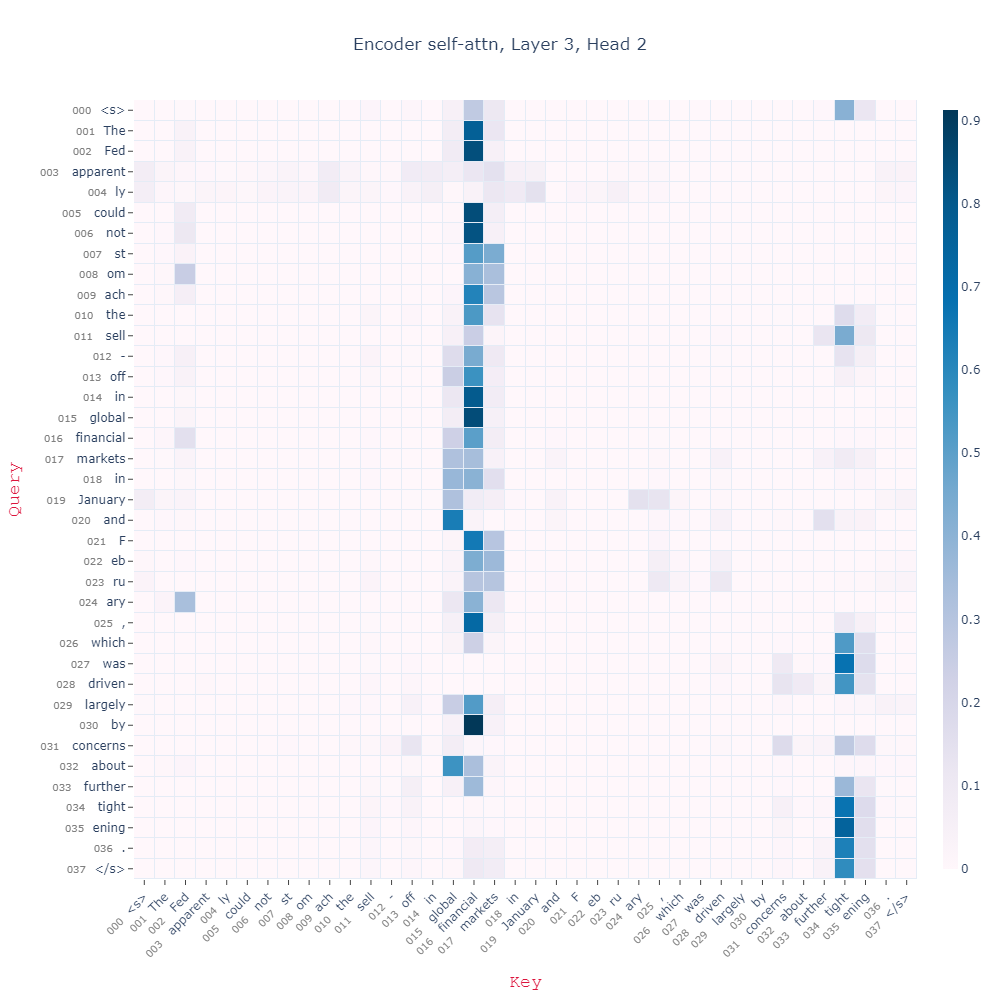

In [125]:
# The above block should produce a similar but not the same (due to randomness) figure as below
Image(filename='images/encoder_self_attn.png')

In [126]:
attn_score.shape        # [batch_size, num_heads, seq_len, seq_len]

(1, 8, 38, 38)

In [127]:
# num_layers = 6
# num_heads = attn_score.shape[1]

In [128]:
# for layer in [0, 5]:
#     for head in [0, 3, 7]:

#         # Encoder self-attention score
#         attn_score = model.encoder.layers[layer].self_attn.attn_score    # [batch_size, num_heads, seq_len, seq_len]
#         attn_score = attn_score.cpu().numpy()

#         matrix = attn_score[0][head]

#         title = f'Encoder self-attn, Layer {layer}, Head {head}'

#         xlabels = [tokenizer.decode(x) for x in batch['src'][0]]
#         ylabels = xlabels
        
#         vis_attn(
#             matrix,
#             xlabels,
#             ylabels,
#             title=title
#         )

## Decoder Visualization [greedy decoding]
* Self-attention
* Cross-attention

### Decoder self-attention

In [129]:
# layer and head to visualize
layer = 1
head = 0

# Decoder self-attention score
attn_score = model.decoder.layers[layer].self_attn.attn_score    # [batch_size, num_heads, seq_len, seq_len]
attn_score = attn_score.cpu().numpy()

matrix = attn_score[0][head]

title = f'Decoder self-attn, Layer {layer}, Head {head}'

# 然而，greedy_decode 并未用到 decoder input，即 batch['tgt']，
# 而是直接以 bos_token_id （在这里为0）开始，一步一步（autoregressive）生成每一个目标文本token。
# 因此，在此 decoder 的 self-attention 应该展示为 greedy decode 产生的文本（又作为decoder的输入）之间的 self-attention，
# 并非 batch['tgt'] 的 self-attention

# Under `greedy_decode`
# 1. should not use batch['tgt'] to show the decoder self-attention
# xlabels = [tokenizer.decode(x) for x in batch['tgt'][0]]
# ylabels = xlabels

# 2. should use model outputs to show the decoder self-attention
xlabels = [tokenizer.decode(x) for x in output_ids[0][:-1]]    # -1: exclude last token which is not involved in the attention calculation
ylabels = xlabels

In [130]:
matrix.shape

(49, 49)

In [131]:
output_ids.shape

torch.Size([1, 50])

In [132]:
results = tokenizer.batch_decode(output_ids)
results

['<s>美联储显然无法在1月和2月间断全球金融市场，这主要是因为担心进一步紧缩。</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>']

In [133]:
vis_attn(
    matrix,
    xlabels,
    ylabels,
    title=title
)

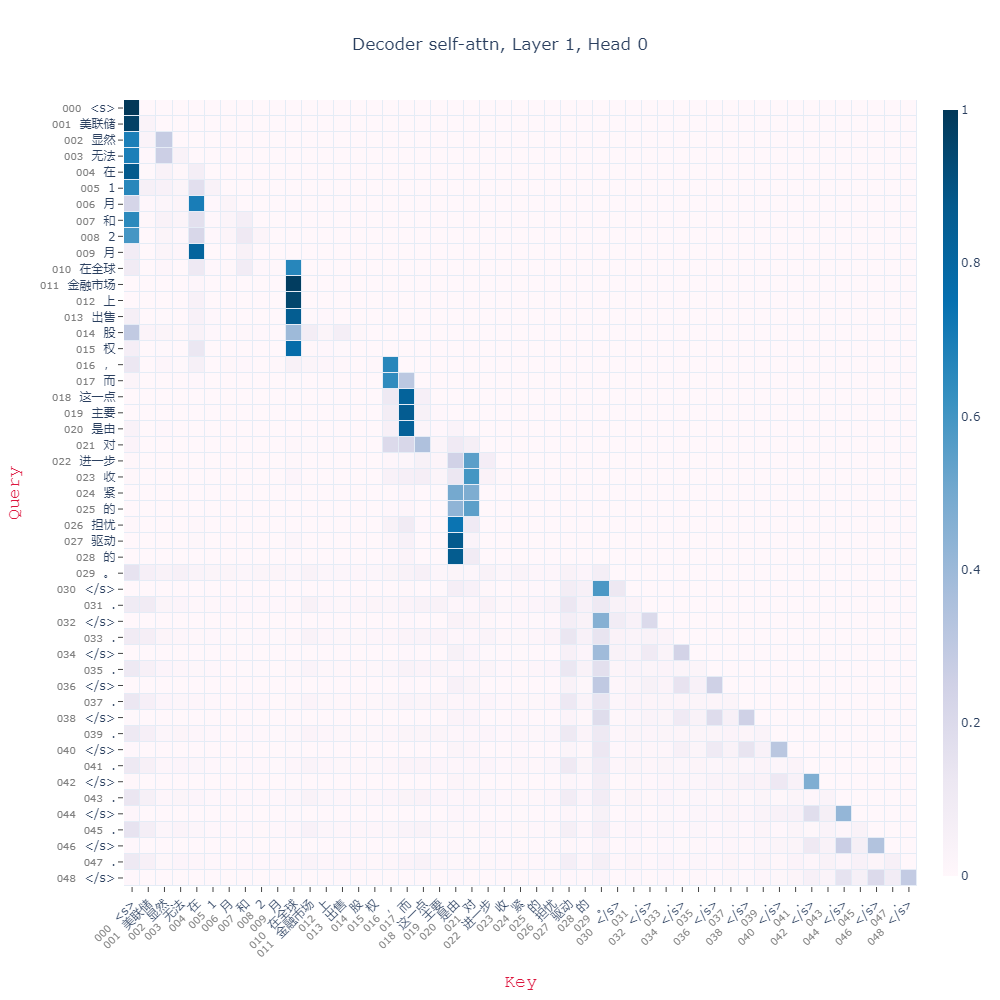

In [134]:
Image(filename='images/decoder_self_attn1.png')

### Decoder cross-attention

Decoder side (Chinese) is the query, and encoder side (English) is the key

In [135]:
# layer and head to visualize
layer = 2
head = 1

# Decoder cross-attention score: decoder input query encoder output
attn_score = model.decoder.layers[layer].cross_attn.attn_score    # [batch_size, num_heads, seq_len, seq_len]
attn_score = attn_score.cpu().numpy()

matrix = attn_score[0][head]

title = f'Decoder cross-attn, Layer {layer}, Head {head}'

query_labels = [tokenizer.decode(x) for x in output_ids[0][:-1]]    # -1: exclude last token which is not involved in the attention calculation
key_labels = [tokenizer.decode(x) for x in batch['src'][0]]

In [136]:
matrix.shape

(49, 38)

In [137]:
len(ylabels), len(xlabels)

(49, 49)

In [138]:
vis_attn(
    matrix,
    xlabels=key_labels,
    ylabels=query_labels,
    title=title
)

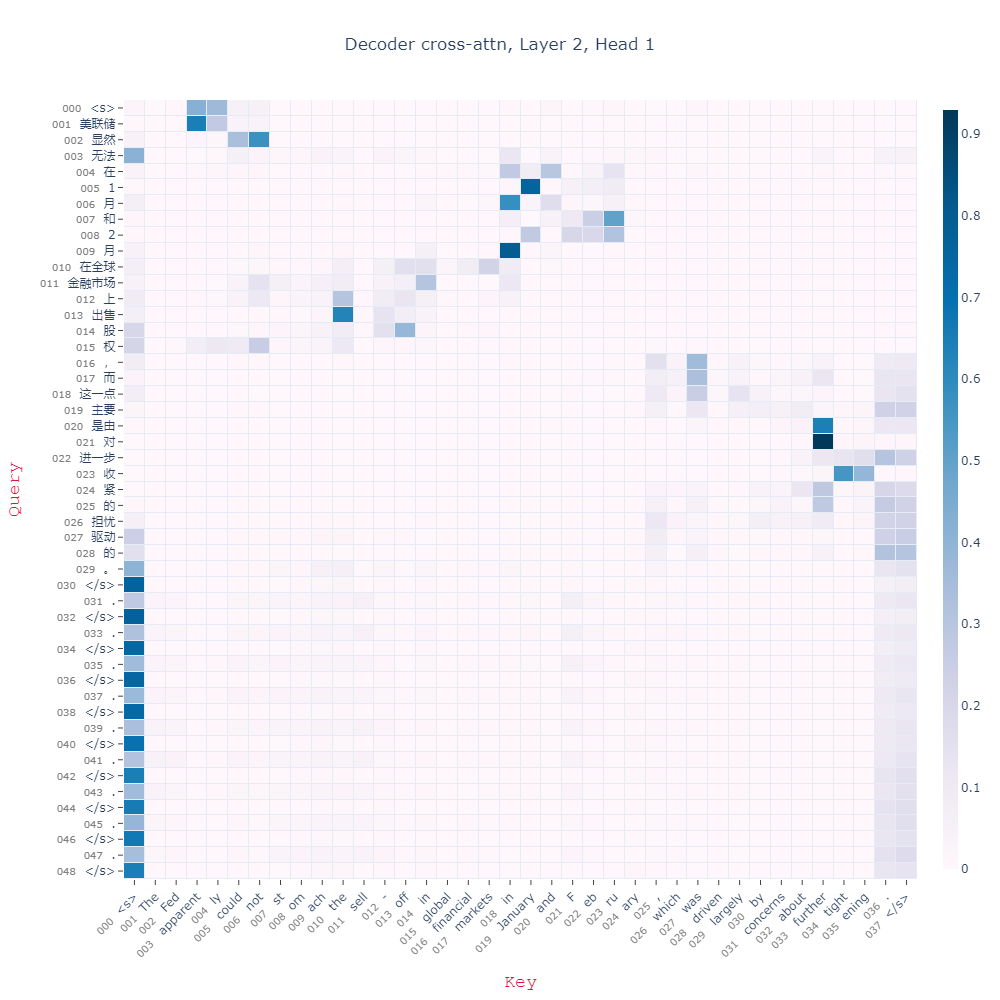

In [139]:
Image(filename='images/decoder_cross_attn1.png')

## Decoder Visualization [teacher force]

* self-attention
* cross-attention

In [140]:
{k:v.shape for k,v in batch.items()}

{'src': torch.Size([1, 38]),
 'src_mask': torch.Size([1, 1, 38]),
 'tgt': torch.Size([1, 31]),
 'tgt_y': torch.Size([1, 31]),
 'tgt_mask': torch.Size([1, 31, 31]),
 'num_tokens': torch.Size([])}

> 上面的例子中，我们采用的 greedy_decode 并未用到 decoder input，即 `batch['tgt']`，
> 因此，在此 decoder 的 self-attention 应该展示为 greedy decode 产生的文本（又作为decoder输入）之间的 self-attention，
> 并非 `batch['tgt']` 的 self-attention。
>
> 这里, 我们使用 `batch['tgt']` 直接作为输入（记为 teacher-forece），展示另一种 decoder 端的 attention。


> In the examples above, the `greedy_decode` method does not utilize the decoder input, i.e., `batch['tgt']`.  
> Therefore, the self-attention in the decoder should represent the self-attention between the text generated 
> by the greedy decode (which is also used as the decoder input in the next autoregressive step), 
> rather than the self-attention of `batch['tgt']`.  
>
> Next, we use `batch['tgt']` directly as the input (denoted as teacher-force) to demonstrate another kind of attention on the decoder side.

In [141]:
model.eval()

with torch.inference_mode():
    logits = model(             # decoder output
        batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
    )
    y_pred = model.generator(logits)
    prob = model.generator(logits)
    _, next_tokens = torch.max(prob, dim=-1)


In [142]:
logits.shape

torch.Size([1, 31, 512])

In [143]:
prob.shape

torch.Size([1, 31, 10000])

In [144]:
next_tokens

tensor([[3160, 3348, 1481,  334, 6308,   21, 1196,  349,   22, 1196, 4286, 5529,
          490, 4253,  276,  365,  821, 1541, 4253, 1723, 1723,  868, 2858, 2858,
         2858,  991,  268, 4797,  287,  287,    2]], device='cuda:0')

In [145]:
tokenizer.batch_decode(next_tokens)

['美联储显然无法在耗1月和2月的全球金融市场上售，这这一回售主要主要受进一步进一步进一步收的担忧。。</s>']

### Decoder self-attention

In [146]:
layer = 0
head = 5

# Decoder self-attention score
attn_score = model.decoder.layers[layer].self_attn.attn_score    # [batch_size, num_heads, seq_len, seq_len]
attn_score = attn_score.cpu().numpy()

matrix = attn_score[0][head]

title = f'Decoder self-attn, Layer {layer}, Head {head}'

# 在此 decoder 的 self-attention 应该展示为 batch['tgt'] （作为decoder输入）内部之间的 self-attention，
# teacher-force, not `greedy_decode`, should use batch['tgt'] to show the decoder self-attention

xlabels = [tokenizer.decode(x) for x in batch['tgt'][0]]    # has been shifted right already
ylabels = xlabels

# under `greedy_decode`, should use model outputs to show they decoder self-attention
# xlabels = [tokenizer.decode(x) for x in output_ids[0][:-1]]
# ylabels = xlabels

In [147]:
matrix.shape

(31, 31)

In [148]:
batch['tgt'].shape

torch.Size([1, 31])

In [149]:
tokenizer.batch_decode(batch['tgt'])

['<s>美联储显然无法消化1月和2月的全球金融市场抛售，而这一抛售潮主要是因为对美联储进一步紧缩的担忧导致的。']

In [150]:
next_tokens.shape

torch.Size([1, 31])

In [151]:
tokenizer.batch_decode(next_tokens)

['美联储显然无法在耗1月和2月的全球金融市场上售，这这一回售主要主要受进一步进一步进一步收的担忧。。</s>']

In [152]:
vis_attn(
    matrix,
    xlabels,
    ylabels,
    title=title
)

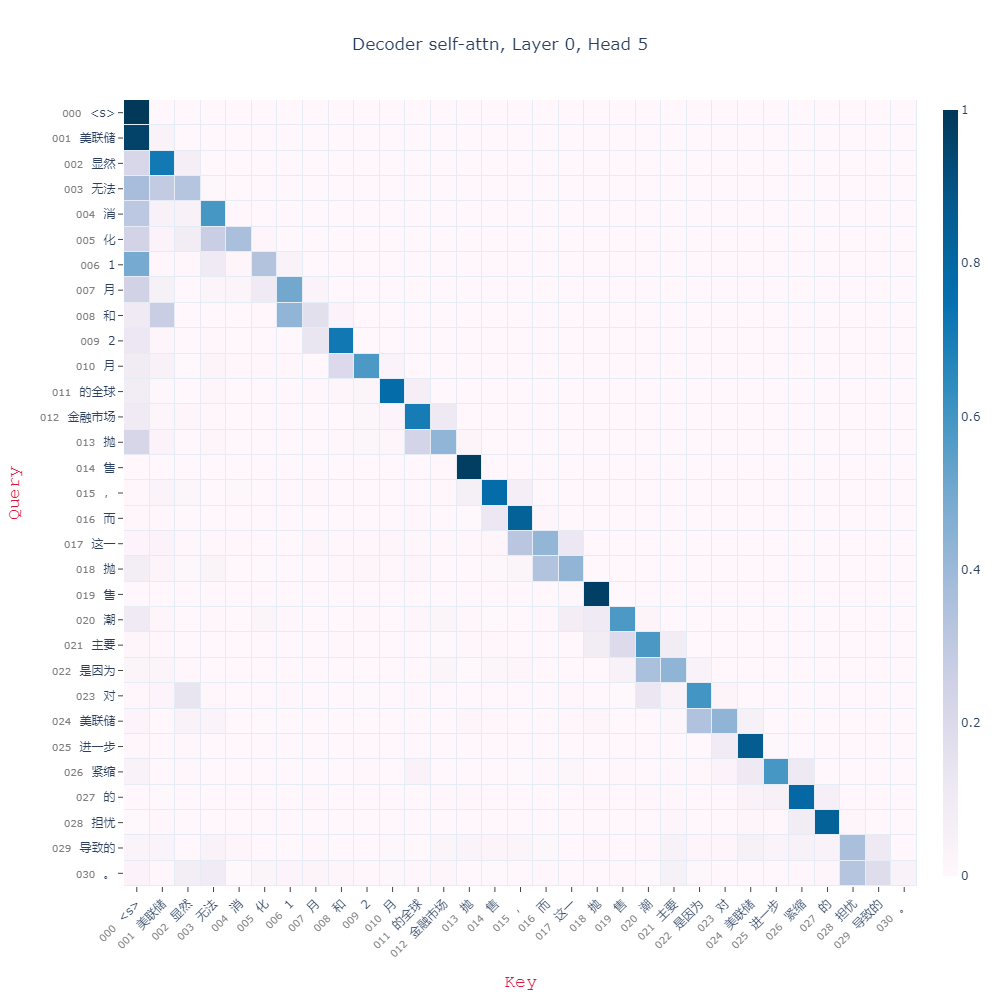

In [153]:
Image(filename='images/decoder_self_attn2.png')

### Decoder cross-attention

Decoder side (Chinese) is the query, and encoder side (English) is the key

In [154]:
layer = 2
head = 6

# Decoder cross-attention score: decoder input query encoder output
attn_score = model.decoder.layers[layer].cross_attn.attn_score    # [batch_size, num_heads, seq_len, seq_len]
attn_score = attn_score.cpu().numpy()

matrix = attn_score[0][head]

title = f'Decoder cross-attn, Layer {layer}, Head {head}'

query_labels = [tokenizer.decode(x) for x in batch['tgt'][0]]       # has been shifted right already
key_labels = [tokenizer.decode(x) for x in batch['src'][0]]

In [155]:
matrix.shape

(31, 38)

In [156]:
len(query_labels), len(key_labels)

(31, 38)

In [157]:
vis_attn(
    matrix,
    xlabels=key_labels,
    ylabels=query_labels,
    title=title
)

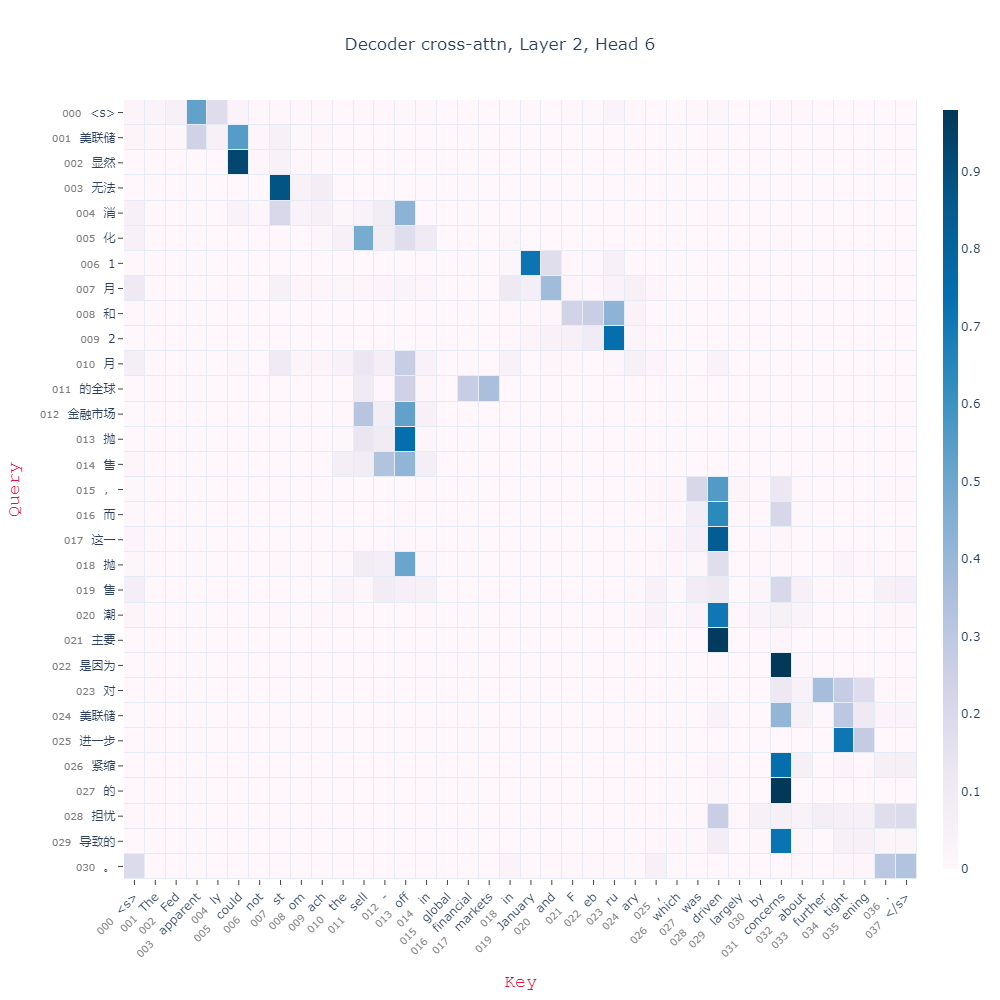

In [158]:
Image(filename='images/decoder_cross_attn2.png')

<br>

# Conclusion


This post updates the original implementation of Annotated Transformer. 
By incorporating a custom-trained RoBERTa tokenizer, we enable effective tokenization tailored to an English-to-Chinese translation task. 
The use of Plotly for visualization enhances interactivity and clarity, providing insights into the model's attention mechanisms. 
Improvements in batching and data collation ensure efficient handling of variable-length sequences, 
making the model more adaptable to real-world datasets.

Future work could explore additional enhancements, such as integrating beam search for decoding, 
transfer learning with larger multilingual datasets, or implementing model ensembling to improve translation quality further. 
